## IMPORTS

In [ ]:
import os
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import ctypes
import gc
import random
import warnings
from PIL import Image, ImageOps, ImageEnhance
from functools import partial
from timm.models.vision_transformer import PatchEmbed, Block
from skimage import io, transform
from torchmetrics.functional.image import peak_signal_noise_ratio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
from torchmetrics import Accuracy
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

torch.manual_seed(42)
libc = ctypes.CDLL("libc.so.6")

## VISUALISE LR and HR

In [2]:
# Define dataset paths
lr_folder = "/kaggle/input/mae-sr-dataset-split/train/LR"
hr_folder = "/kaggle/input/mae-sr-dataset-split/train/HR"

lr_file = os.listdir(lr_folder)[0]  # First file in LR folder
hr_file = os.listdir(hr_folder)[0]  # First file in HR folder

# Load the .npy files
lr_image = np.load(os.path.join(lr_folder, lr_file))
hr_image = np.load(os.path.join(hr_folder, hr_file))

# Print shapes and first few pixel values
print(f"LR Image Shape: {lr_image.shape}")
print(f"HR Image Shape: {hr_image.shape}")

LR Image Shape: (1, 75, 75)
HR Image Shape: (1, 150, 150)


In [3]:
lr_image[0].shape

(75, 75)

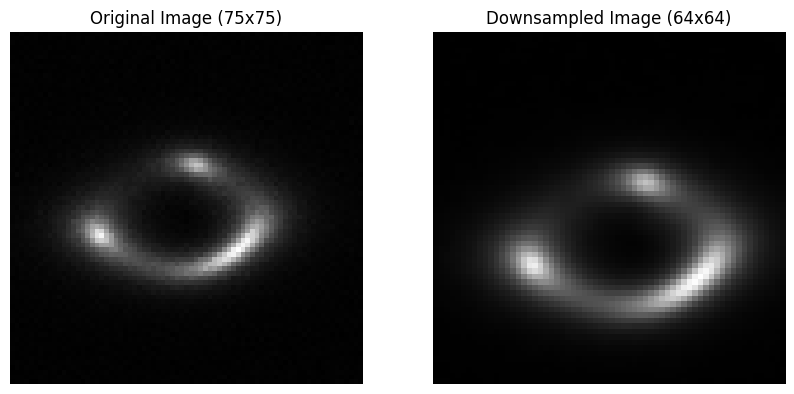

In [4]:
##Encoder Takes 64 x 64 images. Plotting manual downsampling kernel operation

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def downsample_image(image):
    # Define a simple averaging kernel (3x3)
    kernel = np.ones((3, 3)) / 9

    # Apply convolution (valid mode to remove border effects)
    convolved_image = convolve2d(image, kernel, mode='valid')

    # Extract the central 64x64 region
    downsampled_image = convolved_image[:64, :64]

    return downsampled_image



downsampled_image = downsample_image(lr_image[0])

# Plot the original and downsampled images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(lr_image[0], cmap='gray')
axes[0].set_title("Original Image (75x75)")
axes[0].axis("off")

axes[1].imshow(downsampled_image, cmap='gray')
axes[1].set_title("Downsampled Image (64x64)")
axes[1].axis("off")

plt.show()


In [5]:
##Decoder Scales 64 x 64 to 128 x 128
##Figuring out what kernel size for 'deconvolution' produces 150 x 150 output

ip = torch.randn(1, 1, 128, 128)
op = torch.Size([1, 1, 150, 150])
upsample = nn.ConvTranspose2d(1,1, 25, stride=1, padding=1)
output = upsample(ip, output_size = op)


In [6]:
output.shape

torch.Size([1, 1, 150, 150])

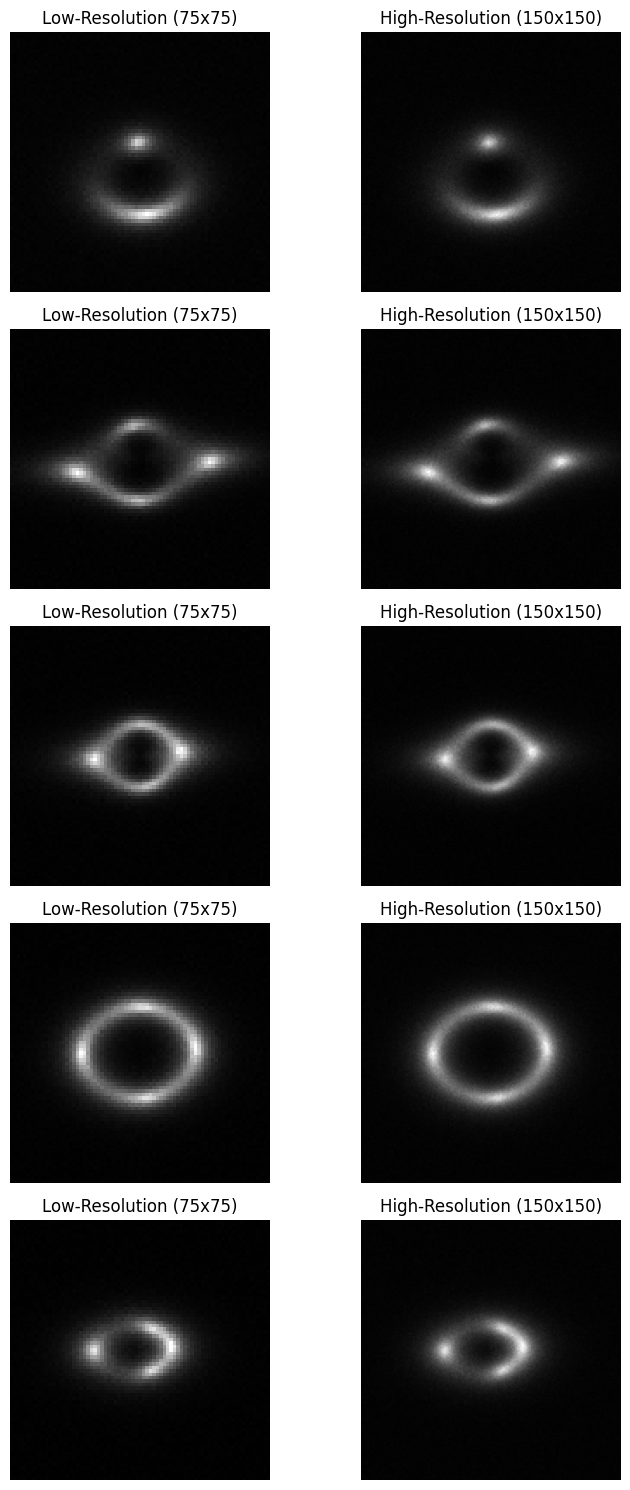

In [7]:

# Get all filenames (assuming corresponding filenames exist in both folders)
lr_files = sorted(os.listdir(lr_folder))
hr_files = sorted(os.listdir(hr_folder))

# Select random samples
num_samples = 5  # Change this to see more samples
random_indices = random.sample(range(len(lr_files)), num_samples)

# Plot the images
fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))

for i, idx in enumerate(random_indices):
    # Load LR and HR images
    lr_image = np.load(os.path.join(lr_folder, lr_files[idx]))  # Shape: (1, 75, 75)
    hr_image = np.load(os.path.join(hr_folder, hr_files[idx]))  # Shape: (1, 150, 150)

    # Squeeze to remove the extra dimension (convert from (1, H, W) → (H, W))
    lr_image = np.squeeze(lr_image)
    hr_image = np.squeeze(hr_image)

    # Display LR Image
    axes[i, 0].imshow(lr_image, cmap="gray")
    axes[i, 0].set_title("Low-Resolution (75x75)")
    axes[i, 0].axis("off")

    # Display HR Image
    axes[i, 1].imshow(hr_image, cmap="gray")
    axes[i, 1].set_title("High-Resolution (150x150)")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## ARRANGE GIVEN DATA INTO TRAIN VAL SPLITS


# This dataset can be found publicly availiable on Kaggle.  Link - [mae_sr_dataset_split](http://www.kaggle.com/datasets/mldtype/mae-sr-dataset-split)


In [4]:
# import os
# import shutil
# import random
# import zipfile

# def split_dataset(root_dir, output_dir, split_ratio=0.9):
#     random.seed(42)
    
#     #source folders
#     hr_dir = os.path.join(root_dir, "HR")
#     lr_dir = os.path.join(root_dir, "LR")
    
#     #output structure
#     train_hr_dir = os.path.join(output_dir, "train", "HR")
#     train_lr_dir = os.path.join(output_dir, "train", "LR")
#     val_hr_dir = os.path.join(output_dir, "val", "HR")
#     val_lr_dir = os.path.join(output_dir, "val", "LR")
    
#     # Create directories
#     for dir_path in [train_hr_dir, train_lr_dir, val_hr_dir, val_lr_dir]:
#         os.makedirs(dir_path, exist_ok=True)
    
#     # Get all filenames
#     hr_files = sorted(os.listdir(hr_dir))
#     lr_files = sorted(os.listdir(lr_dir))
    
#     # Ensure matching files
#     assert len(hr_files) == len(lr_files), "HR and LR folders must have the same number of files"
    
#     # Shuffle and split
#     total_files = len(hr_files)
#     split_idx = int(total_files * split_ratio)
#     indices = list(range(total_files))
#     random.shuffle(indices)
    
#     train_indices = indices[:split_idx]
#     val_indices = indices[split_idx:]
    
#     # Move files
#     for idx in train_indices:
#         shutil.copy(os.path.join(hr_dir, hr_files[idx]), train_hr_dir)
#         shutil.copy(os.path.join(lr_dir, lr_files[idx]), train_lr_dir)
    
#     for idx in val_indices:
#         shutil.copy(os.path.join(hr_dir, hr_files[idx]), val_hr_dir)
#         shutil.copy(os.path.join(lr_dir, lr_files[idx]), val_lr_dir)
    
#     print("Dataset split complete.")
    
#     # Zip the dataset
#     zip_filename = os.path.join(output_dir, "dataset.zip")
#     with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#         for root, _, files in os.walk(output_dir):
#             for file in files:
#                 file_path = os.path.join(root, file)
#                 arcname = os.path.relpath(file_path, output_dir)
#                 zipf.write(file_path, arcname)
    
#     print(f"Zipped dataset saved to {zip_filename}")




In [5]:

# split_dataset("/kaggle/input/mae-sr-dataset/Dataset", "/kaggle/working/")

Dataset split complete.
Zipped dataset saved to /kaggle/working/dataset.zip


In [5]:
# from IPython.display import FileLink

# file_path = "dataset.zip"
# FileLink(file_path)

## MAE MODEL

```
Official Code - https://github.com/facebookresearch/mae/blob/main/models_mae.py
This version is adapted for 1 channel images. Encoder and Decoder are decoupled as separate entities. 
Some helper functions are implemented outside the model class - patchify, unpatchify
We use BCELogits Loss instead of MSE
```

In [8]:




def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def patchify(imgs, img_size, patch_size, in_chans, embed_dim):
    """
    imgs: (N, in_chans, H, W)
    x: (N, L, patch_size**2 *in_chans)
    """
    patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
    p = patch_embed.patch_size[0]
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    
    # in_ch is 1
    x = imgs.reshape(shape=(imgs.shape[0], in_chans, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * in_chans))
    return x

def unpatchify(x, img_size, patch_size, in_chans, embed_dim):
    """
    x: (N, L, patch_size**2 *in_chans)
    imgs: (N, in_chans, H, W)
    """
    patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
    p = patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, in_chans))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], in_chans, h * p, h * p))
    return imgs


#Original Code for ViT had 
class Encoder(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=1, mask_ratio = 0.75,
                 embed_dim=256, depth=12, num_heads=8,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = mask_ratio
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
        # embed patches
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :] # add pos embed w/o cls token

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore
    
class Decoder(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=1, embed_dim = 256,
                 decoder_embed_dim=128, decoder_depth=4, decoder_num_heads=4,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def forward(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = patchify(imgs, 64, 4, 1, 256)
        criterion = nn.BCEWithLogitsLoss(reduction = "mean")
        loss = criterion(pred, target)
        return loss

    def forward_loss_mse(self, imgs, pred, mask):
        target = patchify(imgs, 64, 4, 1, 256)
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs):
        latent, mask, ids_restore = self.encoder(imgs)
        pred = self.decoder(latent, ids_restore)
        bce_loss = self.forward_loss(imgs, pred, mask)
        # mse_loss = self.forward_loss_mse(imgs, pred, mask)
        return bce_loss, pred, mask

## SUPER RESOLUTION MODEL

In [9]:
class SuperResolutionMAE(nn.Module):
    def __init__(self, pretrained_mae, upscale_factor=2):
        super().__init__()
        
        # Pretrained MAE components
        self.encoder = pretrained_mae.encoder
        self.decoder = pretrained_mae.decoder
        
        # Upscaler: Converts decoder output (64x64) → (150x150)
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        self.upscaler = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Initial feature extraction
            nn.ReLU(),
            
            nn.Conv2d(64, 256, kernel_size=3, padding=1),  # Prepare for PixelShuffle
            nn.PixelShuffle(2),  # Upscales 64x64 → 128x128
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # Feature refinement
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

        # Additional upscaling to 150x150
        self.final_upsample = nn.ConvTranspose2d(1,1, 25, stride=1, padding=1)



    def forward(self, lr_image):
        """
        Forward pass:
        - Downscale 75x75 input → 64x64
        - Pass through MAE encoder-decoder
        - Upscale output to 150x150
        """
        # Step 1: Downscale to 64x64
        # kernel = torch.ones(1, 1, 3, 3, device=lr_image.device, dtype=lr_image.dtype) / 9.0
        convolved_image =self.conv(lr_image)
        resized_input = convolved_image[:, :, :64, :64]  # Shape: (batch, 1, 64, 64)

        # Step 2: Encode & Decode using MAE
        latent, mask, ids_restore = self.encoder(resized_input)
        decoded = self.decoder(latent, ids_restore)

        # Step 3: Upscale to 150x150
        hr_image = self.upscaler(decoded.view(-1, 1, 64, 64))
        hr_image = self.final_upsample(hr_image, output_size = torch.Size([1, 1, 150, 150]))

        return hr_image


In [10]:
##Pixel Values are already b/w (0, 1) so no excess normalisation is used

class SRDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, transform=None):
        self.lr_folder = lr_folder
        self.hr_folder = hr_folder
        self.transform = transform
        
        # Assuming matching filenames in both folders
        self.filenames = sorted(os.listdir(lr_folder))  # Ensure order matches
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        
        # Load .npy images
        lr_img_path = os.path.join(self.lr_folder, filename)
        hr_img_path = os.path.join(self.hr_folder, filename)
        
        lr_img = np.load(lr_img_path)  # Shape: (75, 75)
        hr_img = np.load(hr_img_path)  # Shape: (150, 150)
        
        # Convert to float tensors
        lr_img = torch.tensor(lr_img, dtype=torch.float32)
        hr_img = torch.tensor(hr_img, dtype=torch.float32)

        return lr_img, hr_img


In [11]:
def show_images(lr, sr, hr):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    images = [lr, sr, hr]
    titles = ['Low-Resolution (Input)', 'Super-Resolved (Output)', 'High-Resolution (Ground Truth)']

    for i, ax in enumerate(axes):
        img = images[i].squeeze().detach().cpu().numpy()  # Convert tensor to numpy
        ax.imshow(img, cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')

    plt.show()

In [21]:
def mae_vit_base(img_size=64, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=4, in_chans= 1,mask_ratio = 0.75,
        embed_dim=256, depth=8, num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=4, in_chans = 1, embed_dim=256,
        decoder_embed_dim=128, decoder_depth=4, decoder_num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model



In [22]:
mae = mae_vit_base(64)
ckpt = torch.load("/kaggle/input/weights-ml4sci-all/best_mae_vit_model_256emb_final.pth", map_location="cpu")
new_state_dict = {k.replace("module.", ""):ckpt[k] for k in ckpt.keys()}
mae.load_state_dict(new_state_dict, strict=True)

<ipython-input-22-b4d0fcbb0e0a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/input/weights-ml4sci-all/best_mae_vit_model_256emb_final.pth", ma

<All keys matched successfully>

In [23]:
model = SuperResolutionMAE(pretrained_mae=mae)

In [25]:
##Dummy input test
model(torch.randn(1,1,75,75)).shape

torch.Size([1, 1, 150, 150])

## TRAIN MODEL

```
PSNR, SSIM, MSE are tracked. L1 loss is used for optimisation, MSE quickly drops to lower values, hence avoided. It showed slower convergence.
```

In [12]:
def train_model(
    model, 
    epochs, 
    train_dataloader, 
    val_dataloader, 
    device, 
    optimizer, 
    scheduler, 
    log_file_path="training_log.txt",
    weights_path="best_model.pth",
    model_name="SR_Model",
    train_tqdm_tag="Train",
    val_tqdm_tag="Val"
):
    best_psnr = 0.0  
    train_losses = []
    val_losses = []

    # Loss functions
    l1_loss_fn = nn.L1Loss()
    mse_loss_fn = nn.MSELoss()

    # Open log file
    with open(log_file_path, "w") as log_file:
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            train_mse = 0.0  # Track MSE loss for training

            for lr_img, hr_img in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [{train_tqdm_tag}]', unit='batch'):
                optimizer.zero_grad()
                
                lr_img = lr_img.to(device).float()
                hr_img = hr_img.to(device).float()

                sr_img = model(lr_img)

                # Compute losses
                l1_loss = l1_loss_fn(sr_img, hr_img)
                mse_loss = mse_loss_fn(sr_img, hr_img)  # Compute MSE loss

                loss = l1_loss  # Using L1 loss for optimization

                loss.backward()
                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                train_mse += mse_loss.item()

            train_loss /= len(train_dataloader)
            train_mse /= len(train_dataloader)  # Average MSE loss
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_mse = 0.0  # Track MSE loss for validation
            total_psnr = 0.0
            total_ssim = 0.0
            num_samples = 0

            with torch.no_grad():
                for lr_img, hr_img in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{epochs} [{val_tqdm_tag}]', unit='batch'):
                    lr_img = lr_img.to(device).float()
                    hr_img = hr_img.to(device).float()

                    sr_img = model(lr_img)

                    # Compute losses
                    l1_loss = l1_loss_fn(sr_img, hr_img)
                    mse_loss = mse_loss_fn(sr_img, hr_img)

                    val_loss += l1_loss.item()
                    val_mse += mse_loss.item()

                    # Convert tensors to numpy for PSNR & SSIM calculation
                    sr_np = np.clip(sr_img.squeeze().cpu().numpy(), 0, 1)
                    hr_np = np.clip(hr_img.squeeze().cpu().numpy(), 0, 1)
                    
                    psnr_val = psnr(hr_np, sr_np, data_range=hr_np.max() - hr_np.min())
                    ssim_val = ssim(hr_np, sr_np, data_range=hr_np.max() - hr_np.min(), multichannel=False)

                    total_psnr += psnr_val
                    total_ssim += ssim_val
                    num_samples += 1
            
            val_loss /= len(val_dataloader)
            val_mse /= len(val_dataloader)  # Average MSE loss
            avg_psnr = total_psnr / num_samples
            avg_ssim = total_ssim / num_samples
            val_losses.append(val_loss)

            log_msg = (f'Epoch {epoch+1}/{epochs}, '
                       f'Train Loss: {train_loss:.6f}, Train MSE: {train_mse:.6f}, '
                       f'Val Loss: {val_loss:.6f}, Val MSE: {val_mse:.6f}, '
                       f'PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}\n')
            
            print(log_msg)
            log_file.write(log_msg)

            # Save model if PSNR improves
            if avg_psnr > best_psnr:
                best_psnr = avg_psnr
                torch.save(model.state_dict(), weights_path)
                print(f"Best model '{model_name}' saved with PSNR: {best_psnr:.4f}")

            torch.cuda.empty_cache()
            gc.collect()

            if (epoch + 1) % 10 == 0:
                visualize_samples(lr_img, sr_img, hr_img)

    return train_losses, val_losses

def visualize_samples(lr_img, sr_img, hr_img):
    lr_img = lr_img.cpu().detach().numpy()
    sr_img = sr_img.cpu().detach().numpy()
    hr_img = hr_img.cpu().detach().numpy()

    if len(lr_img.shape) == 4:
        lr_img = lr_img[0, 0]  
        sr_img = sr_img[0, 0]
        hr_img = hr_img[0, 0]

    images = [lr_img, sr_img, hr_img]
    titles = ["Low-Resolution", "Super-Resolved", "High-Resolution"]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')

    plt.show()


In [13]:
transform = None
train = SRDataset("/kaggle/input/mae-sr-dataset-split/train/LR","/kaggle/input/mae-sr-dataset-split/train/HR", transform = transform)
val =  SRDataset("/kaggle/input/mae-sr-dataset-split/val/LR","/kaggle/input/mae-sr-dataset-split/val/HR", transform = transform)
train_dataloader = DataLoader(train, batch_size = 512, shuffle = True)
val_dataloader = DataLoader(val, batch_size = 512, shuffle = False)

## Load Pretrained MAE

In [14]:
def mae_vit_base(img_size=64, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=4, in_chans= 1,mask_ratio = 0.75,
        embed_dim=256, depth=8, num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=4, in_chans = 1, embed_dim=256,
        decoder_embed_dim=128, decoder_depth=4, decoder_num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model

mae = mae_vit_base(64)
ckpt = torch.load("/kaggle/input/weights-ml4sci-all/best_mae_vit_model_256emb_final.pth")
new_state_dict = {k.replace("module.", ""):ckpt[k] for k in ckpt.keys()}
mae.load_state_dict(new_state_dict, strict=True)

<ipython-input-14-3c832b7b1d45>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/input/weights-ml4sci-all/best_mae_vit_model_256emb_final.pth")


<All keys matched successfully>

## FINETUNING WITH FREEZED ENCODER. ~1M params

```
I have used learnable convolution to downsample input image for encoder input dim. Averaging static filter can also be used.
However, I observed that leanable filter performs better hence kept.
```

Total number of trainable parameters: 996173


Epoch 1/150 [Val]: 100%|██████████| 2/2 [00:25<00:00, 12.50s/batch]


Epoch 1/150, Train Loss: 0.082923, Train MSE: 0.021438, Val Loss: 0.053618, Val MSE: 0.012832, PSNR: 18.9625, SSIM: 0.4466

Best model 'SRMAE' saved with PSNR: 18.9625


Epoch 2/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.56s/batch]


Epoch 2/150, Train Loss: 0.049449, Train MSE: 0.012433, Val Loss: 0.045608, Val MSE: 0.011122, PSNR: 19.5704, SSIM: 0.5166

Best model 'SRMAE' saved with PSNR: 19.5704


Epoch 3/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/batch]


Epoch 3/150, Train Loss: 0.044160, Train MSE: 0.010900, Val Loss: 0.042633, Val MSE: 0.010755, PSNR: 19.6947, SSIM: 0.5581

Best model 'SRMAE' saved with PSNR: 19.6947


Epoch 4/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.65s/batch]


Epoch 4/150, Train Loss: 0.041972, Train MSE: 0.010805, Val Loss: 0.041494, Val MSE: 0.011075, PSNR: 19.5583, SSIM: 0.5990



Epoch 5/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.43s/batch]


Epoch 5/150, Train Loss: 0.040645, Train MSE: 0.010741, Val Loss: 0.040014, Val MSE: 0.010499, PSNR: 19.7885, SSIM: 0.6331

Best model 'SRMAE' saved with PSNR: 19.7885


Epoch 6/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.45s/batch]


Epoch 6/150, Train Loss: 0.040466, Train MSE: 0.010784, Val Loss: 0.039804, Val MSE: 0.011091, PSNR: 19.5505, SSIM: 0.6405



Epoch 7/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.31s/batch]


Epoch 7/150, Train Loss: 0.040595, Train MSE: 0.010810, Val Loss: 0.039664, Val MSE: 0.011479, PSNR: 19.4012, SSIM: 0.6598



Epoch 8/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.33s/batch]


Epoch 8/150, Train Loss: 0.039353, Train MSE: 0.010493, Val Loss: 0.038621, Val MSE: 0.009838, PSNR: 20.0711, SSIM: 0.6523

Best model 'SRMAE' saved with PSNR: 20.0711


Epoch 9/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.47s/batch]


Epoch 9/150, Train Loss: 0.038053, Train MSE: 0.010091, Val Loss: 0.037568, Val MSE: 0.009421, PSNR: 20.2592, SSIM: 0.6619

Best model 'SRMAE' saved with PSNR: 20.2592


Epoch 10/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.32s/batch]


Epoch 10/150, Train Loss: 0.037373, Train MSE: 0.009529, Val Loss: 0.036308, Val MSE: 0.009324, PSNR: 20.3040, SSIM: 0.6725

Best model 'SRMAE' saved with PSNR: 20.3040


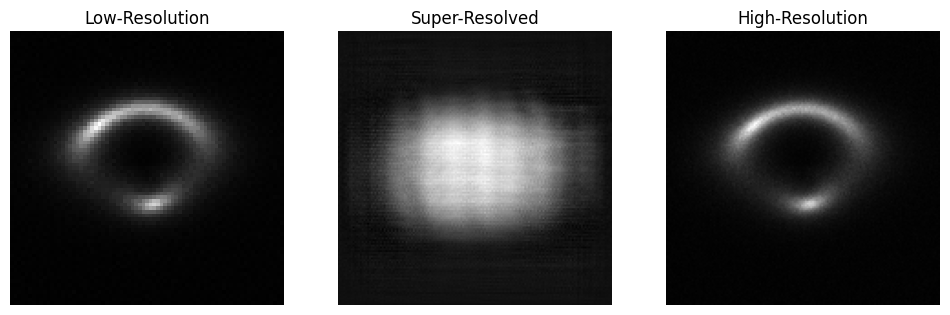

Epoch 11/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/batch]


Epoch 11/150, Train Loss: 0.055926, Train MSE: 0.015135, Val Loss: 0.048643, Val MSE: 0.014911, PSNR: 18.2650, SSIM: 0.6141



Epoch 12/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.46s/batch]


Epoch 12/150, Train Loss: 0.048809, Train MSE: 0.014693, Val Loss: 0.048382, Val MSE: 0.014554, PSNR: 18.3700, SSIM: 0.6022



Epoch 13/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.40s/batch]


Epoch 13/150, Train Loss: 0.048064, Train MSE: 0.014524, Val Loss: 0.047735, Val MSE: 0.014594, PSNR: 18.3582, SSIM: 0.6197



Epoch 14/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.43s/batch]


Epoch 14/150, Train Loss: 0.047587, Train MSE: 0.014409, Val Loss: 0.047455, Val MSE: 0.014232, PSNR: 18.4672, SSIM: 0.6111



Epoch 15/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 15/150, Train Loss: 0.047339, Train MSE: 0.014274, Val Loss: 0.047232, Val MSE: 0.014229, PSNR: 18.4681, SSIM: 0.6154



Epoch 16/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.31s/batch]


Epoch 16/150, Train Loss: 0.047098, Train MSE: 0.014194, Val Loss: 0.046974, Val MSE: 0.014145, PSNR: 18.4939, SSIM: 0.6170



Epoch 17/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.27s/batch]


Epoch 17/150, Train Loss: 0.046857, Train MSE: 0.014081, Val Loss: 0.046658, Val MSE: 0.014014, PSNR: 18.5344, SSIM: 0.6177



Epoch 18/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.27s/batch]


Epoch 18/150, Train Loss: 0.046460, Train MSE: 0.013888, Val Loss: 0.046124, Val MSE: 0.013782, PSNR: 18.6069, SSIM: 0.6188



Epoch 19/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.31s/batch]


Epoch 19/150, Train Loss: 0.045565, Train MSE: 0.013530, Val Loss: 0.044395, Val MSE: 0.013044, PSNR: 18.8460, SSIM: 0.6230



Epoch 20/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.41s/batch]


Epoch 20/150, Train Loss: 0.042076, Train MSE: 0.011539, Val Loss: 0.040364, Val MSE: 0.010505, PSNR: 19.7859, SSIM: 0.6180



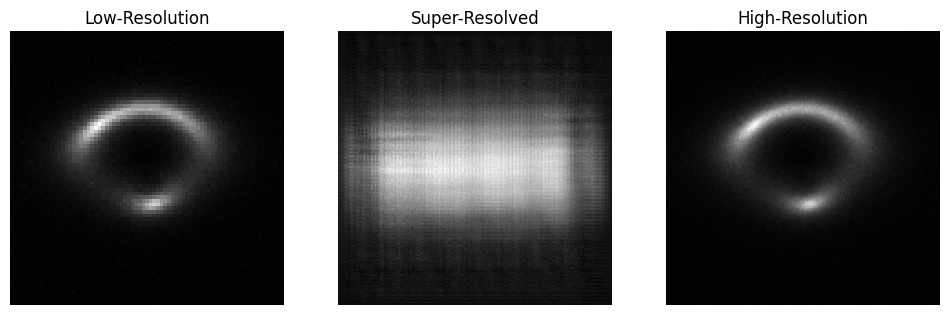

Epoch 21/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.39s/batch]


Epoch 21/150, Train Loss: 0.039585, Train MSE: 0.010668, Val Loss: 0.038646, Val MSE: 0.010518, PSNR: 19.7807, SSIM: 0.6575



Epoch 22/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 22/150, Train Loss: 0.037863, Train MSE: 0.009964, Val Loss: 0.036911, Val MSE: 0.009432, PSNR: 20.2539, SSIM: 0.6665



Epoch 23/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.39s/batch]


Epoch 23/150, Train Loss: 0.036745, Train MSE: 0.009340, Val Loss: 0.036512, Val MSE: 0.009625, PSNR: 20.1662, SSIM: 0.6755



Epoch 24/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.31s/batch]


Epoch 24/150, Train Loss: 0.036613, Train MSE: 0.009295, Val Loss: 0.036282, Val MSE: 0.008827, PSNR: 20.5420, SSIM: 0.6781

Best model 'SRMAE' saved with PSNR: 20.5420


Epoch 25/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.49s/batch]


Epoch 25/150, Train Loss: 0.036059, Train MSE: 0.009089, Val Loss: 0.035738, Val MSE: 0.009170, PSNR: 20.3766, SSIM: 0.6796



Epoch 26/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.31s/batch]


Epoch 26/150, Train Loss: 0.035523, Train MSE: 0.008897, Val Loss: 0.035246, Val MSE: 0.008575, PSNR: 20.6677, SSIM: 0.6851

Best model 'SRMAE' saved with PSNR: 20.6677


Epoch 27/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.32s/batch]


Epoch 27/150, Train Loss: 0.036920, Train MSE: 0.009279, Val Loss: 0.038165, Val MSE: 0.007960, PSNR: 20.9908, SSIM: 0.6596

Best model 'SRMAE' saved with PSNR: 20.9908


Epoch 28/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.40s/batch]


Epoch 28/150, Train Loss: 0.035993, Train MSE: 0.008906, Val Loss: 0.035833, Val MSE: 0.009034, PSNR: 20.4410, SSIM: 0.6816



Epoch 29/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 29/150, Train Loss: 0.034455, Train MSE: 0.008411, Val Loss: 0.033360, Val MSE: 0.008140, PSNR: 20.8936, SSIM: 0.6934



Epoch 30/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.33s/batch]


Epoch 30/150, Train Loss: 0.032509, Train MSE: 0.007556, Val Loss: 0.031833, Val MSE: 0.007229, PSNR: 21.4095, SSIM: 0.7057

Best model 'SRMAE' saved with PSNR: 21.4095


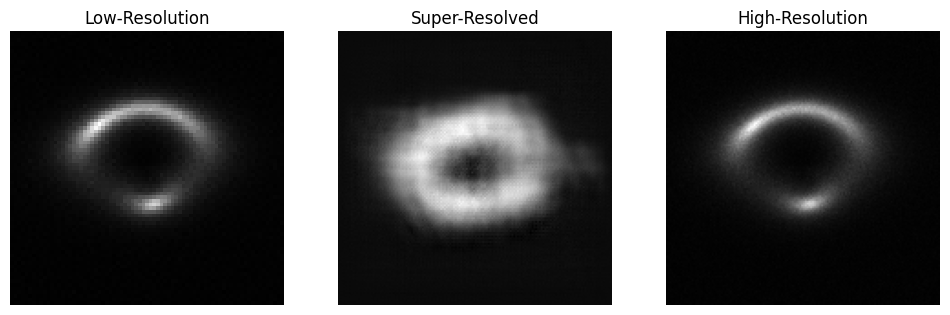

Epoch 31/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 31/150, Train Loss: 0.032385, Train MSE: 0.007415, Val Loss: 0.031264, Val MSE: 0.006738, PSNR: 21.7147, SSIM: 0.7166

Best model 'SRMAE' saved with PSNR: 21.7147


Epoch 32/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.32s/batch]


Epoch 32/150, Train Loss: 0.035553, Train MSE: 0.008809, Val Loss: 0.044983, Val MSE: 0.013814, PSNR: 18.5968, SSIM: 0.6478



Epoch 33/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.52s/batch]


Epoch 33/150, Train Loss: 0.039157, Train MSE: 0.009874, Val Loss: 0.034820, Val MSE: 0.006934, PSNR: 21.5913, SSIM: 0.6779



Epoch 34/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.29s/batch]


Epoch 34/150, Train Loss: 0.033428, Train MSE: 0.007703, Val Loss: 0.032824, Val MSE: 0.008264, PSNR: 20.8285, SSIM: 0.6954



Epoch 35/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.40s/batch]


Epoch 35/150, Train Loss: 0.031527, Train MSE: 0.007101, Val Loss: 0.030773, Val MSE: 0.006734, PSNR: 21.7171, SSIM: 0.7205

Best model 'SRMAE' saved with PSNR: 21.7171


Epoch 36/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.33s/batch]


Epoch 36/150, Train Loss: 0.030567, Train MSE: 0.006730, Val Loss: 0.030010, Val MSE: 0.006455, PSNR: 21.9011, SSIM: 0.7305

Best model 'SRMAE' saved with PSNR: 21.9011


Epoch 37/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.30s/batch]


Epoch 37/150, Train Loss: 0.029928, Train MSE: 0.006515, Val Loss: 0.029410, Val MSE: 0.006149, PSNR: 22.1123, SSIM: 0.7415

Best model 'SRMAE' saved with PSNR: 22.1123


Epoch 38/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 38/150, Train Loss: 0.030106, Train MSE: 0.006501, Val Loss: 0.030008, Val MSE: 0.006536, PSNR: 21.8469, SSIM: 0.7312



Epoch 39/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 39/150, Train Loss: 0.029903, Train MSE: 0.006528, Val Loss: 0.029406, Val MSE: 0.006382, PSNR: 21.9503, SSIM: 0.7419



Epoch 40/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.29s/batch]


Epoch 40/150, Train Loss: 0.029093, Train MSE: 0.006187, Val Loss: 0.028628, Val MSE: 0.006081, PSNR: 22.1601, SSIM: 0.7484

Best model 'SRMAE' saved with PSNR: 22.1601


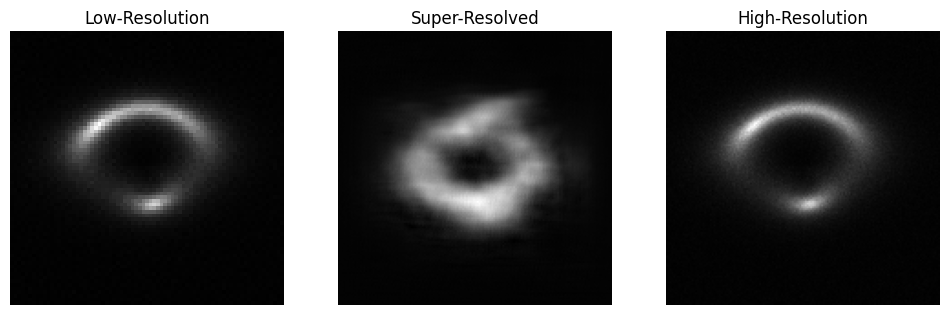

Epoch 41/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 41/150, Train Loss: 0.028832, Train MSE: 0.006103, Val Loss: 0.028398, Val MSE: 0.005765, PSNR: 22.3922, SSIM: 0.7558

Best model 'SRMAE' saved with PSNR: 22.3922


Epoch 42/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.49s/batch]


Epoch 42/150, Train Loss: 0.028751, Train MSE: 0.006050, Val Loss: 0.028120, Val MSE: 0.005970, PSNR: 22.2404, SSIM: 0.7544



Epoch 43/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.56s/batch]


Epoch 43/150, Train Loss: 0.028376, Train MSE: 0.005924, Val Loss: 0.028339, Val MSE: 0.006163, PSNR: 22.1025, SSIM: 0.7490



Epoch 44/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.41s/batch]


Epoch 44/150, Train Loss: 0.027880, Train MSE: 0.005801, Val Loss: 0.030226, Val MSE: 0.005228, PSNR: 22.8168, SSIM: 0.7752

Best model 'SRMAE' saved with PSNR: 22.8168


Epoch 45/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.47s/batch]


Epoch 45/150, Train Loss: 0.034676, Train MSE: 0.008639, Val Loss: 0.033681, Val MSE: 0.008241, PSNR: 20.8402, SSIM: 0.6983



Epoch 46/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 46/150, Train Loss: 0.035088, Train MSE: 0.008159, Val Loss: 0.031796, Val MSE: 0.007026, PSNR: 21.5333, SSIM: 0.7022



Epoch 47/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.47s/batch]


Epoch 47/150, Train Loss: 0.031025, Train MSE: 0.006773, Val Loss: 0.029842, Val MSE: 0.006564, PSNR: 21.8281, SSIM: 0.7281



Epoch 48/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.42s/batch]


Epoch 48/150, Train Loss: 0.029471, Train MSE: 0.006375, Val Loss: 0.028927, Val MSE: 0.005999, PSNR: 22.2192, SSIM: 0.7485



Epoch 49/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.41s/batch]


Epoch 49/150, Train Loss: 0.028609, Train MSE: 0.006078, Val Loss: 0.028399, Val MSE: 0.006163, PSNR: 22.1022, SSIM: 0.7529



Epoch 50/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.45s/batch]


Epoch 50/150, Train Loss: 0.027986, Train MSE: 0.005826, Val Loss: 0.027570, Val MSE: 0.005716, PSNR: 22.4293, SSIM: 0.7656



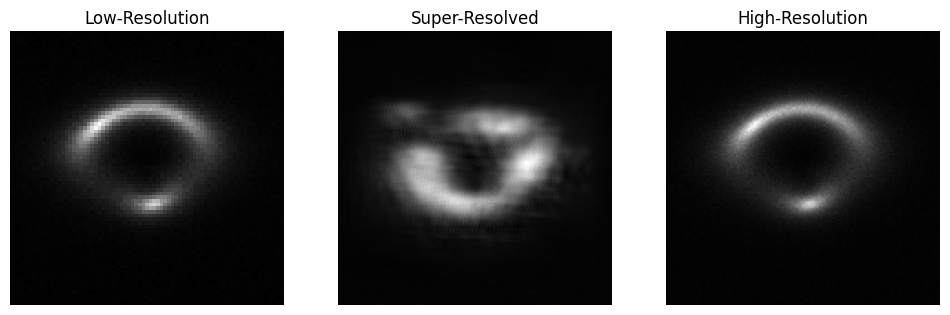

Epoch 51/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.39s/batch]


Epoch 51/150, Train Loss: 0.028072, Train MSE: 0.005853, Val Loss: 0.027998, Val MSE: 0.005429, PSNR: 22.6525, SSIM: 0.7708



Epoch 52/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/batch]


Epoch 52/150, Train Loss: 0.028774, Train MSE: 0.006055, Val Loss: 0.028230, Val MSE: 0.005846, PSNR: 22.3316, SSIM: 0.7553



Epoch 53/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/batch]


Epoch 53/150, Train Loss: 0.028184, Train MSE: 0.005814, Val Loss: 0.028483, Val MSE: 0.006484, PSNR: 21.8816, SSIM: 0.7551



Epoch 54/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.33s/batch]


Epoch 54/150, Train Loss: 0.028625, Train MSE: 0.006022, Val Loss: 0.028336, Val MSE: 0.006285, PSNR: 22.0170, SSIM: 0.7508



Epoch 55/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.45s/batch]


Epoch 55/150, Train Loss: 0.027689, Train MSE: 0.005674, Val Loss: 0.026976, Val MSE: 0.005609, PSNR: 22.5110, SSIM: 0.7727



Epoch 56/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.46s/batch]


Epoch 56/150, Train Loss: 0.027228, Train MSE: 0.005507, Val Loss: 0.026542, Val MSE: 0.005455, PSNR: 22.6321, SSIM: 0.7803



Epoch 57/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.40s/batch]


Epoch 57/150, Train Loss: 0.026640, Train MSE: 0.005317, Val Loss: 0.026004, Val MSE: 0.005174, PSNR: 22.8621, SSIM: 0.7922

Best model 'SRMAE' saved with PSNR: 22.8621


Epoch 58/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.54s/batch]


Epoch 58/150, Train Loss: 0.025803, Train MSE: 0.005050, Val Loss: 0.025754, Val MSE: 0.004715, PSNR: 23.2647, SSIM: 0.8059

Best model 'SRMAE' saved with PSNR: 23.2647


Epoch 59/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.51s/batch]


Epoch 59/150, Train Loss: 0.025685, Train MSE: 0.004959, Val Loss: 0.026875, Val MSE: 0.004700, PSNR: 23.2786, SSIM: 0.8073

Best model 'SRMAE' saved with PSNR: 23.2786


Epoch 60/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.40s/batch]


Epoch 60/150, Train Loss: 0.025736, Train MSE: 0.004932, Val Loss: 0.024162, Val MSE: 0.004608, PSNR: 23.3652, SSIM: 0.8187

Best model 'SRMAE' saved with PSNR: 23.3652


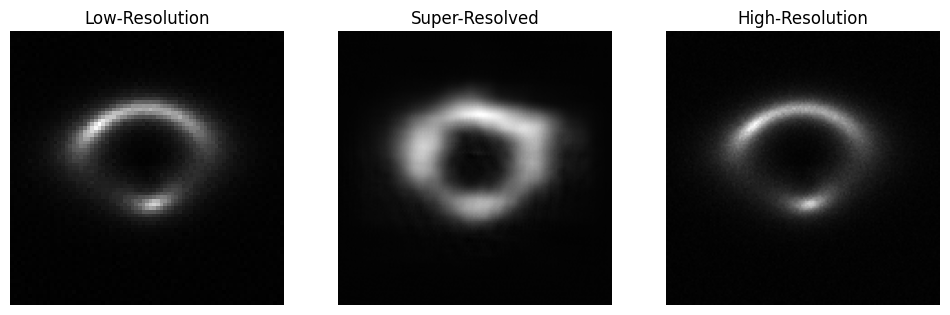

Epoch 61/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.49s/batch]


Epoch 61/150, Train Loss: 0.025219, Train MSE: 0.004754, Val Loss: 0.023509, Val MSE: 0.004302, PSNR: 23.6638, SSIM: 0.8313

Best model 'SRMAE' saved with PSNR: 23.6638


Epoch 62/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.37s/batch]


Epoch 62/150, Train Loss: 0.025290, Train MSE: 0.004714, Val Loss: 0.026003, Val MSE: 0.004809, PSNR: 23.1795, SSIM: 0.8083



Epoch 63/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.56s/batch]


Epoch 63/150, Train Loss: 0.024610, Train MSE: 0.004511, Val Loss: 0.023641, Val MSE: 0.004008, PSNR: 23.9707, SSIM: 0.8350

Best model 'SRMAE' saved with PSNR: 23.9707


Epoch 64/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.90s/batch]


Epoch 64/150, Train Loss: 0.023419, Train MSE: 0.004119, Val Loss: 0.024428, Val MSE: 0.004503, PSNR: 23.4655, SSIM: 0.8165



Epoch 65/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.70s/batch]


Epoch 65/150, Train Loss: 0.024313, Train MSE: 0.004334, Val Loss: 0.022808, Val MSE: 0.004006, PSNR: 23.9727, SSIM: 0.8377

Best model 'SRMAE' saved with PSNR: 23.9727


Epoch 66/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/batch]


Epoch 66/150, Train Loss: 0.023455, Train MSE: 0.004081, Val Loss: 0.022335, Val MSE: 0.003894, PSNR: 24.0959, SSIM: 0.8445

Best model 'SRMAE' saved with PSNR: 24.0959


Epoch 67/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.40s/batch]


Epoch 67/150, Train Loss: 0.022766, Train MSE: 0.003892, Val Loss: 0.022422, Val MSE: 0.003732, PSNR: 24.2804, SSIM: 0.8471

Best model 'SRMAE' saved with PSNR: 24.2804


Epoch 68/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.43s/batch]


Epoch 68/150, Train Loss: 0.022496, Train MSE: 0.003776, Val Loss: 0.022149, Val MSE: 0.003813, PSNR: 24.1872, SSIM: 0.8504



Epoch 69/150 [Val]: 100%|██████████| 2/2 [00:06<00:00,  3.15s/batch]


Epoch 69/150, Train Loss: 0.026084, Train MSE: 0.004903, Val Loss: 0.030436, Val MSE: 0.006723, PSNR: 21.7246, SSIM: 0.7514



Epoch 70/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.90s/batch]


Epoch 70/150, Train Loss: 0.026116, Train MSE: 0.004901, Val Loss: 0.023428, Val MSE: 0.003993, PSNR: 23.9871, SSIM: 0.8351



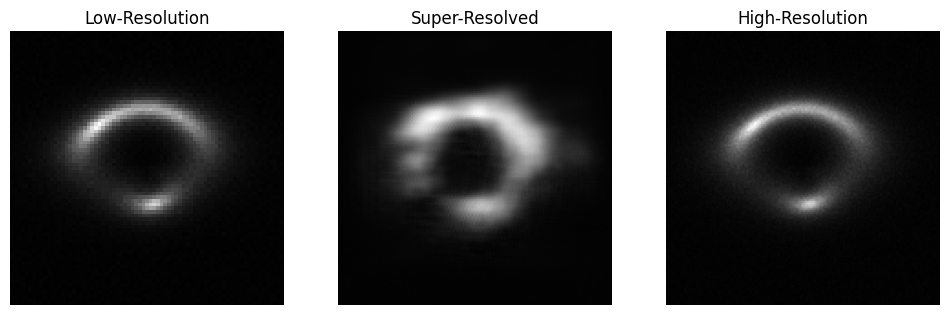

Epoch 71/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.54s/batch]


Epoch 71/150, Train Loss: 0.022989, Train MSE: 0.003854, Val Loss: 0.021903, Val MSE: 0.003461, PSNR: 24.6084, SSIM: 0.8524

Best model 'SRMAE' saved with PSNR: 24.6084


Epoch 72/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.59s/batch]


Epoch 72/150, Train Loss: 0.021842, Train MSE: 0.003488, Val Loss: 0.021289, Val MSE: 0.003292, PSNR: 24.8257, SSIM: 0.8572

Best model 'SRMAE' saved with PSNR: 24.8257


Epoch 73/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.39s/batch]


Epoch 73/150, Train Loss: 0.022697, Train MSE: 0.003822, Val Loss: 0.023918, Val MSE: 0.003593, PSNR: 24.4459, SSIM: 0.8471



Epoch 74/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.37s/batch]


Epoch 74/150, Train Loss: 0.025315, Train MSE: 0.004539, Val Loss: 0.025451, Val MSE: 0.004951, PSNR: 23.0532, SSIM: 0.8145



Epoch 75/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.67s/batch]


Epoch 75/150, Train Loss: 0.023740, Train MSE: 0.004190, Val Loss: 0.022077, Val MSE: 0.003744, PSNR: 24.2666, SSIM: 0.8509



Epoch 76/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.78s/batch]


Epoch 76/150, Train Loss: 0.022244, Train MSE: 0.003622, Val Loss: 0.021306, Val MSE: 0.003767, PSNR: 24.2402, SSIM: 0.8584



Epoch 77/150 [Val]: 100%|██████████| 2/2 [00:08<00:00,  4.08s/batch]


Epoch 77/150, Train Loss: 0.022446, Train MSE: 0.003691, Val Loss: 0.020521, Val MSE: 0.003073, PSNR: 25.1251, SSIM: 0.8734

Best model 'SRMAE' saved with PSNR: 25.1251


Epoch 79/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.79s/batch]


Epoch 79/150, Train Loss: 0.020731, Train MSE: 0.003154, Val Loss: 0.021992, Val MSE: 0.003283, PSNR: 24.8377, SSIM: 0.8627



Epoch 80/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.49s/batch]


Epoch 80/150, Train Loss: 0.020300, Train MSE: 0.003022, Val Loss: 0.019266, Val MSE: 0.002898, PSNR: 25.3795, SSIM: 0.8838

Best model 'SRMAE' saved with PSNR: 25.3795


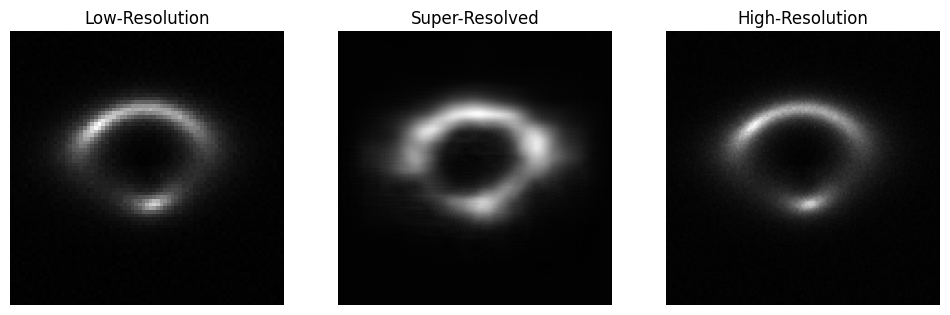

Epoch 81/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.69s/batch]


Epoch 81/150, Train Loss: 0.019404, Train MSE: 0.002812, Val Loss: 0.018898, Val MSE: 0.002725, PSNR: 25.6458, SSIM: 0.8896

Best model 'SRMAE' saved with PSNR: 25.6458


Epoch 82/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.30s/batch]


Epoch 82/150, Train Loss: 0.019265, Train MSE: 0.002758, Val Loss: 0.019124, Val MSE: 0.002553, PSNR: 25.9296, SSIM: 0.8956

Best model 'SRMAE' saved with PSNR: 25.9296


Epoch 83/150 [Val]: 100%|██████████| 2/2 [00:06<00:00,  3.26s/batch]


Epoch 83/150, Train Loss: 0.019987, Train MSE: 0.002918, Val Loss: 0.019389, Val MSE: 0.002728, PSNR: 25.6416, SSIM: 0.8846



Epoch 84/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.58s/batch]


Epoch 84/150, Train Loss: 0.020744, Train MSE: 0.003112, Val Loss: 0.020118, Val MSE: 0.003191, PSNR: 24.9610, SSIM: 0.8741



Epoch 85/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.99s/batch]


Epoch 85/150, Train Loss: 0.019718, Train MSE: 0.002807, Val Loss: 0.018600, Val MSE: 0.002452, PSNR: 26.1049, SSIM: 0.8979

Best model 'SRMAE' saved with PSNR: 26.1049


Epoch 86/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.81s/batch]


Epoch 86/150, Train Loss: 0.020441, Train MSE: 0.003056, Val Loss: 0.019606, Val MSE: 0.002688, PSNR: 25.7067, SSIM: 0.8914



Epoch 87/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.63s/batch]


Epoch 87/150, Train Loss: 0.019662, Train MSE: 0.002876, Val Loss: 0.018569, Val MSE: 0.002609, PSNR: 25.8346, SSIM: 0.8955



Epoch 88/150 [Val]: 100%|██████████| 2/2 [00:07<00:00,  3.70s/batch]


Epoch 88/150, Train Loss: 0.018602, Train MSE: 0.002576, Val Loss: 0.017847, Val MSE: 0.002386, PSNR: 26.2239, SSIM: 0.9025

Best model 'SRMAE' saved with PSNR: 26.2239


Epoch 89/150 [Val]: 100%|██████████| 2/2 [00:07<00:00,  3.91s/batch]


Epoch 89/150, Train Loss: 0.017839, Train MSE: 0.002391, Val Loss: 0.017416, Val MSE: 0.002225, PSNR: 26.5267, SSIM: 0.9073

Best model 'SRMAE' saved with PSNR: 26.5267


Epoch 90/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.65s/batch]


Epoch 90/150, Train Loss: 0.017589, Train MSE: 0.002282, Val Loss: 0.016951, Val MSE: 0.002164, PSNR: 26.6468, SSIM: 0.9107

Best model 'SRMAE' saved with PSNR: 26.6468


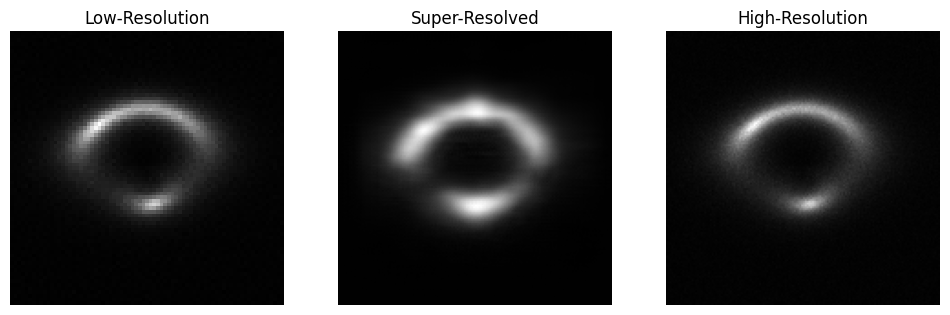

Epoch 91/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.63s/batch]


Epoch 91/150, Train Loss: 0.018639, Train MSE: 0.002542, Val Loss: 0.017760, Val MSE: 0.002306, PSNR: 26.3712, SSIM: 0.9068



Epoch 92/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.88s/batch]


Epoch 92/150, Train Loss: 0.018786, Train MSE: 0.002598, Val Loss: 0.017956, Val MSE: 0.002497, PSNR: 26.0251, SSIM: 0.9014



Epoch 93/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.79s/batch]


Epoch 93/150, Train Loss: 0.018342, Train MSE: 0.002450, Val Loss: 0.017998, Val MSE: 0.002299, PSNR: 26.3845, SSIM: 0.9033



Epoch 94/150 [Val]: 100%|██████████| 2/2 [00:09<00:00,  4.92s/batch]


Epoch 94/150, Train Loss: 0.017291, Train MSE: 0.002193, Val Loss: 0.017370, Val MSE: 0.002291, PSNR: 26.3994, SSIM: 0.9061



Epoch 95/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.64s/batch]


Epoch 95/150, Train Loss: 0.017093, Train MSE: 0.002146, Val Loss: 0.016473, Val MSE: 0.002030, PSNR: 26.9262, SSIM: 0.9154

Best model 'SRMAE' saved with PSNR: 26.9262


Epoch 96/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.99s/batch]


Epoch 96/150, Train Loss: 0.017230, Train MSE: 0.002160, Val Loss: 0.016821, Val MSE: 0.002000, PSNR: 26.9908, SSIM: 0.9181

Best model 'SRMAE' saved with PSNR: 26.9908


Epoch 97/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.60s/batch]


Epoch 97/150, Train Loss: 0.017577, Train MSE: 0.002243, Val Loss: 0.018306, Val MSE: 0.002647, PSNR: 25.7725, SSIM: 0.9009



Epoch 98/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.46s/batch]


Epoch 98/150, Train Loss: 0.019067, Train MSE: 0.002635, Val Loss: 0.018464, Val MSE: 0.002433, PSNR: 26.1380, SSIM: 0.8967



Epoch 99/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.42s/batch]


Epoch 99/150, Train Loss: 0.017582, Train MSE: 0.002252, Val Loss: 0.017461, Val MSE: 0.002102, PSNR: 26.7729, SSIM: 0.9120



Epoch 100/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.51s/batch]


Epoch 100/150, Train Loss: 0.016490, Train MSE: 0.001964, Val Loss: 0.015772, Val MSE: 0.001809, PSNR: 27.4261, SSIM: 0.9231

Best model 'SRMAE' saved with PSNR: 27.4261


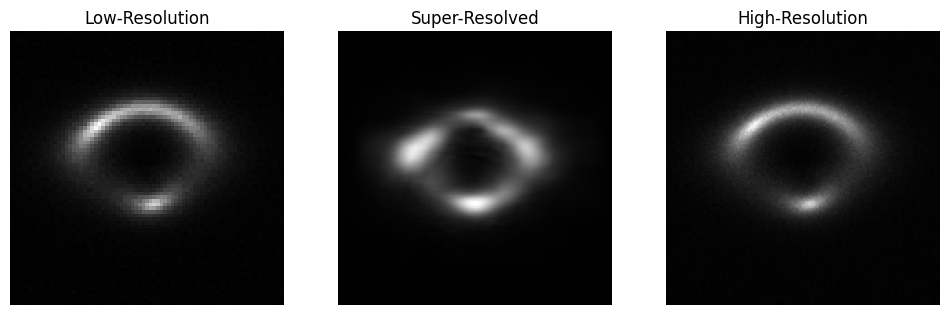

Epoch 101/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.46s/batch]


Epoch 101/150, Train Loss: 0.016731, Train MSE: 0.002021, Val Loss: 0.015787, Val MSE: 0.001855, PSNR: 27.3184, SSIM: 0.9225



Epoch 102/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.43s/batch]


Epoch 102/150, Train Loss: 0.017837, Train MSE: 0.002274, Val Loss: 0.019764, Val MSE: 0.002802, PSNR: 25.5262, SSIM: 0.8733



Epoch 103/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.43s/batch]


Epoch 103/150, Train Loss: 0.019404, Train MSE: 0.002768, Val Loss: 0.018415, Val MSE: 0.002395, PSNR: 26.2079, SSIM: 0.9029



Epoch 104/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.42s/batch]


Epoch 104/150, Train Loss: 0.017226, Train MSE: 0.002158, Val Loss: 0.017966, Val MSE: 0.002561, PSNR: 25.9167, SSIM: 0.9027



Epoch 105/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.33s/batch]


Epoch 105/150, Train Loss: 0.016832, Train MSE: 0.002041, Val Loss: 0.015631, Val MSE: 0.001798, PSNR: 27.4523, SSIM: 0.9233

Best model 'SRMAE' saved with PSNR: 27.4523


Epoch 106/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.42s/batch]


Epoch 106/150, Train Loss: 0.015793, Train MSE: 0.001803, Val Loss: 0.014963, Val MSE: 0.001631, PSNR: 27.8758, SSIM: 0.9291

Best model 'SRMAE' saved with PSNR: 27.8758


Epoch 107/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.45s/batch]


Epoch 107/150, Train Loss: 0.015018, Train MSE: 0.001613, Val Loss: 0.014978, Val MSE: 0.001642, PSNR: 27.8463, SSIM: 0.9283



Epoch 108/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 108/150, Train Loss: 0.015097, Train MSE: 0.001625, Val Loss: 0.014999, Val MSE: 0.001585, PSNR: 27.9999, SSIM: 0.9290

Best model 'SRMAE' saved with PSNR: 27.9999


Epoch 109/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.44s/batch]


Epoch 109/150, Train Loss: 0.015353, Train MSE: 0.001679, Val Loss: 0.015712, Val MSE: 0.001732, PSNR: 27.6160, SSIM: 0.9275



Epoch 110/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.43s/batch]


Epoch 110/150, Train Loss: 0.015296, Train MSE: 0.001647, Val Loss: 0.014303, Val MSE: 0.001464, PSNR: 28.3452, SSIM: 0.9342

Best model 'SRMAE' saved with PSNR: 28.3452


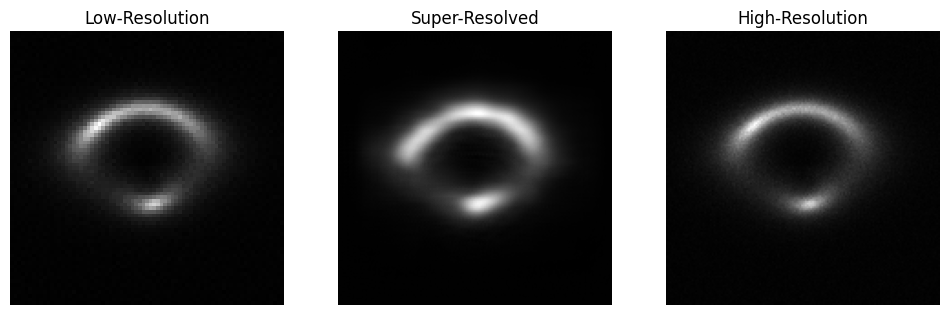

Epoch 111/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.55s/batch]


Epoch 111/150, Train Loss: 0.016404, Train MSE: 0.001908, Val Loss: 0.015599, Val MSE: 0.001647, PSNR: 27.8340, SSIM: 0.9260



Epoch 112/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.37s/batch]


Epoch 112/150, Train Loss: 0.016413, Train MSE: 0.001901, Val Loss: 0.015225, Val MSE: 0.001581, PSNR: 28.0109, SSIM: 0.9309



Epoch 113/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.36s/batch]


Epoch 113/150, Train Loss: 0.015268, Train MSE: 0.001649, Val Loss: 0.014769, Val MSE: 0.001567, PSNR: 28.0496, SSIM: 0.9322



Epoch 114/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.45s/batch]


Epoch 114/150, Train Loss: 0.014636, Train MSE: 0.001507, Val Loss: 0.014795, Val MSE: 0.001526, PSNR: 28.1657, SSIM: 0.9341



Epoch 115/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.37s/batch]


Epoch 115/150, Train Loss: 0.014683, Train MSE: 0.001499, Val Loss: 0.013830, Val MSE: 0.001268, PSNR: 28.9697, SSIM: 0.9409

Best model 'SRMAE' saved with PSNR: 28.9697


Epoch 116/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.42s/batch]


Epoch 116/150, Train Loss: 0.015280, Train MSE: 0.001628, Val Loss: 0.014383, Val MSE: 0.001446, PSNR: 28.4008, SSIM: 0.9350



Epoch 117/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.36s/batch]


Epoch 117/150, Train Loss: 0.015063, Train MSE: 0.001586, Val Loss: 0.015135, Val MSE: 0.001521, PSNR: 28.1797, SSIM: 0.9324



Epoch 118/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.33s/batch]


Epoch 118/150, Train Loss: 0.015641, Train MSE: 0.001674, Val Loss: 0.015243, Val MSE: 0.001607, PSNR: 27.9400, SSIM: 0.9211



Epoch 119/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/batch]


Epoch 119/150, Train Loss: 0.014686, Train MSE: 0.001503, Val Loss: 0.015744, Val MSE: 0.001469, PSNR: 28.3316, SSIM: 0.9363



Epoch 120/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/batch]


Epoch 120/150, Train Loss: 0.014252, Train MSE: 0.001397, Val Loss: 0.013622, Val MSE: 0.001309, PSNR: 28.8302, SSIM: 0.9396



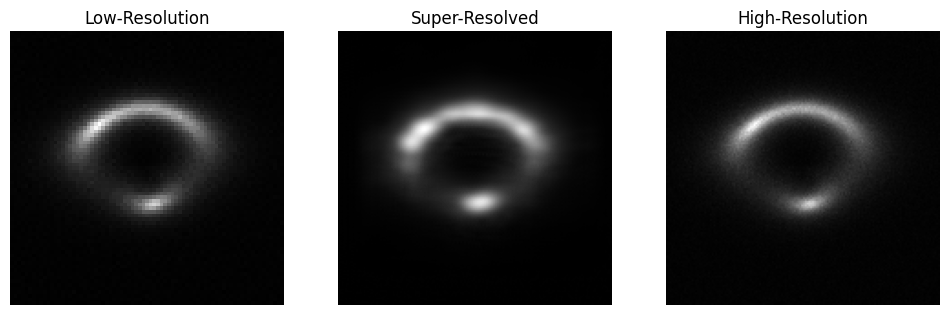

Epoch 121/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 121/150, Train Loss: 0.013961, Train MSE: 0.001341, Val Loss: 0.013564, Val MSE: 0.001202, PSNR: 29.2011, SSIM: 0.9429

Best model 'SRMAE' saved with PSNR: 29.2011


Epoch 122/150 [Val]: 100%|██████████| 2/2 [00:06<00:00,  3.29s/batch]


Epoch 122/150, Train Loss: 0.015732, Train MSE: 0.001669, Val Loss: 0.016123, Val MSE: 0.001985, PSNR: 27.0230, SSIM: 0.9173



Epoch 123/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.44s/batch]


Epoch 123/150, Train Loss: 0.016496, Train MSE: 0.001931, Val Loss: 0.016059, Val MSE: 0.001765, PSNR: 27.5333, SSIM: 0.9259



Epoch 124/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.47s/batch]


Epoch 124/150, Train Loss: 0.014993, Train MSE: 0.001565, Val Loss: 0.015682, Val MSE: 0.001864, PSNR: 27.2949, SSIM: 0.9215



Epoch 125/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.46s/batch]


Epoch 125/150, Train Loss: 0.014540, Train MSE: 0.001467, Val Loss: 0.013655, Val MSE: 0.001269, PSNR: 28.9671, SSIM: 0.9400



Epoch 126/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.92s/batch]


Epoch 126/150, Train Loss: 0.013960, Train MSE: 0.001331, Val Loss: 0.013413, Val MSE: 0.001223, PSNR: 29.1242, SSIM: 0.9417



Epoch 127/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 127/150, Train Loss: 0.013410, Train MSE: 0.001219, Val Loss: 0.013386, Val MSE: 0.001165, PSNR: 29.3364, SSIM: 0.9430

Best model 'SRMAE' saved with PSNR: 29.3364


Epoch 128/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.26s/batch]


Epoch 128/150, Train Loss: 0.013750, Train MSE: 0.001281, Val Loss: 0.016406, Val MSE: 0.001441, PSNR: 28.4146, SSIM: 0.9334



Epoch 129/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.27s/batch]


Epoch 129/150, Train Loss: 0.015603, Train MSE: 0.001656, Val Loss: 0.015133, Val MSE: 0.001601, PSNR: 27.9571, SSIM: 0.9339



Epoch 130/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.29s/batch]


Epoch 130/150, Train Loss: 0.015456, Train MSE: 0.001644, Val Loss: 0.014160, Val MSE: 0.001334, PSNR: 28.7470, SSIM: 0.9378



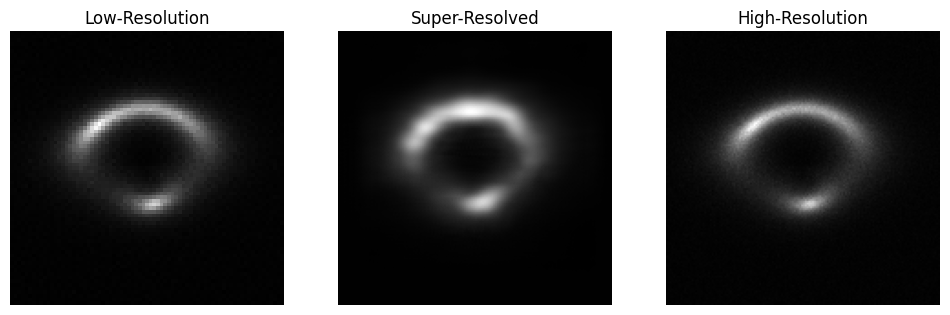

Epoch 131/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.33s/batch]


Epoch 131/150, Train Loss: 0.014453, Train MSE: 0.001449, Val Loss: 0.013652, Val MSE: 0.001202, PSNR: 29.2027, SSIM: 0.9436



Epoch 132/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 132/150, Train Loss: 0.014051, Train MSE: 0.001319, Val Loss: 0.014050, Val MSE: 0.001267, PSNR: 28.9706, SSIM: 0.9396



Epoch 133/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.42s/batch]


Epoch 133/150, Train Loss: 0.013754, Train MSE: 0.001268, Val Loss: 0.013169, Val MSE: 0.001111, PSNR: 29.5442, SSIM: 0.9458

Best model 'SRMAE' saved with PSNR: 29.5442


Epoch 134/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.40s/batch]


Epoch 134/150, Train Loss: 0.013389, Train MSE: 0.001176, Val Loss: 0.014829, Val MSE: 0.001377, PSNR: 28.6096, SSIM: 0.9364



Epoch 135/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.43s/batch]


Epoch 135/150, Train Loss: 0.013660, Train MSE: 0.001227, Val Loss: 0.012818, Val MSE: 0.001026, PSNR: 29.8872, SSIM: 0.9472

Best model 'SRMAE' saved with PSNR: 29.8872


Epoch 136/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.42s/batch]


Epoch 136/150, Train Loss: 0.013783, Train MSE: 0.001256, Val Loss: 0.013187, Val MSE: 0.001094, PSNR: 29.6093, SSIM: 0.9461



Epoch 137/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.39s/batch]


Epoch 137/150, Train Loss: 0.014443, Train MSE: 0.001386, Val Loss: 0.013803, Val MSE: 0.001345, PSNR: 28.7127, SSIM: 0.9384



Epoch 138/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.45s/batch]


Epoch 138/150, Train Loss: 0.014012, Train MSE: 0.001301, Val Loss: 0.013978, Val MSE: 0.001256, PSNR: 29.0097, SSIM: 0.9362



Epoch 139/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.54s/batch]


Epoch 139/150, Train Loss: 0.013854, Train MSE: 0.001288, Val Loss: 0.015523, Val MSE: 0.001417, PSNR: 28.4875, SSIM: 0.9314



Epoch 140/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.51s/batch]


Epoch 140/150, Train Loss: 0.013869, Train MSE: 0.001282, Val Loss: 0.012729, Val MSE: 0.001109, PSNR: 29.5525, SSIM: 0.9466



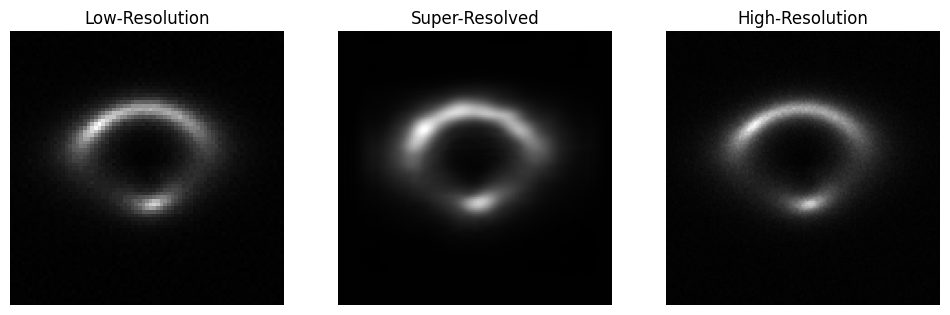

Epoch 141/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.50s/batch]


Epoch 141/150, Train Loss: 0.014666, Train MSE: 0.001414, Val Loss: 0.013339, Val MSE: 0.001223, PSNR: 29.1262, SSIM: 0.9427



Epoch 142/150 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.62s/batch]


Epoch 142/150, Train Loss: 0.013296, Train MSE: 0.001157, Val Loss: 0.013269, Val MSE: 0.001209, PSNR: 29.1740, SSIM: 0.9425



Epoch 143/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.46s/batch]


Epoch 143/150, Train Loss: 0.013777, Train MSE: 0.001251, Val Loss: 0.013734, Val MSE: 0.001314, PSNR: 28.8153, SSIM: 0.9392



Epoch 144/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.24s/batch]


Epoch 144/150, Train Loss: 0.013160, Train MSE: 0.001151, Val Loss: 0.013035, Val MSE: 0.001083, PSNR: 29.6521, SSIM: 0.9476



Epoch 145/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.29s/batch]


Epoch 145/150, Train Loss: 0.012867, Train MSE: 0.001083, Val Loss: 0.011957, Val MSE: 0.000923, PSNR: 30.3489, SSIM: 0.9523

Best model 'SRMAE' saved with PSNR: 30.3489


Epoch 146/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.29s/batch]


Epoch 146/150, Train Loss: 0.013357, Train MSE: 0.001182, Val Loss: 0.012674, Val MSE: 0.001051, PSNR: 29.7829, SSIM: 0.9471



Epoch 147/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.26s/batch]


Epoch 147/150, Train Loss: 0.012885, Train MSE: 0.001077, Val Loss: 0.012494, Val MSE: 0.000996, PSNR: 30.0183, SSIM: 0.9474



Epoch 148/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.33s/batch]


Epoch 148/150, Train Loss: 0.012682, Train MSE: 0.001040, Val Loss: 0.014911, Val MSE: 0.001164, PSNR: 29.3413, SSIM: 0.9400



Epoch 149/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 149/150, Train Loss: 0.013803, Train MSE: 0.001202, Val Loss: 0.015300, Val MSE: 0.001402, PSNR: 28.5332, SSIM: 0.9321



Epoch 150/150 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 150/150, Train Loss: 0.013484, Train MSE: 0.001140, Val Loss: 0.012333, Val MSE: 0.000948, PSNR: 30.2363, SSIM: 0.9495



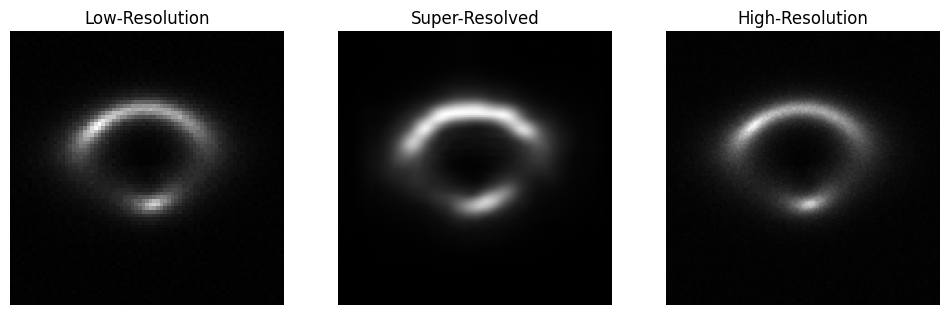

In [17]:
DEVICE = torch.device("cuda:0")
NUM_GPU = torch.cuda.device_count()

model = SuperResolutionMAE(pretrained_mae=mae)
model = model.to(DEVICE)

#Freezed Encoder
for param in model.encoder.parameters():
    param.requires_grad = False  

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

optimizer = optim.AdamW(model.parameters(), lr=9e-4, weight_decay=0.05)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min = 8e-5)


if NUM_GPU > 1:
    model = nn.DataParallel(model)

epochs = 150

train_losses, val_losses = train_model(
    model, 
    epochs=epochs, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    device=DEVICE, 
    optimizer=optimizer, 
    scheduler=scheduler,
    log_file_path="./training_log.txt",
    weights_path="./best_sr_mae_model.pth",
    model_name="SRMAE",
    train_tqdm_tag="SR Training",
    val_tqdm_tag="Val"
)

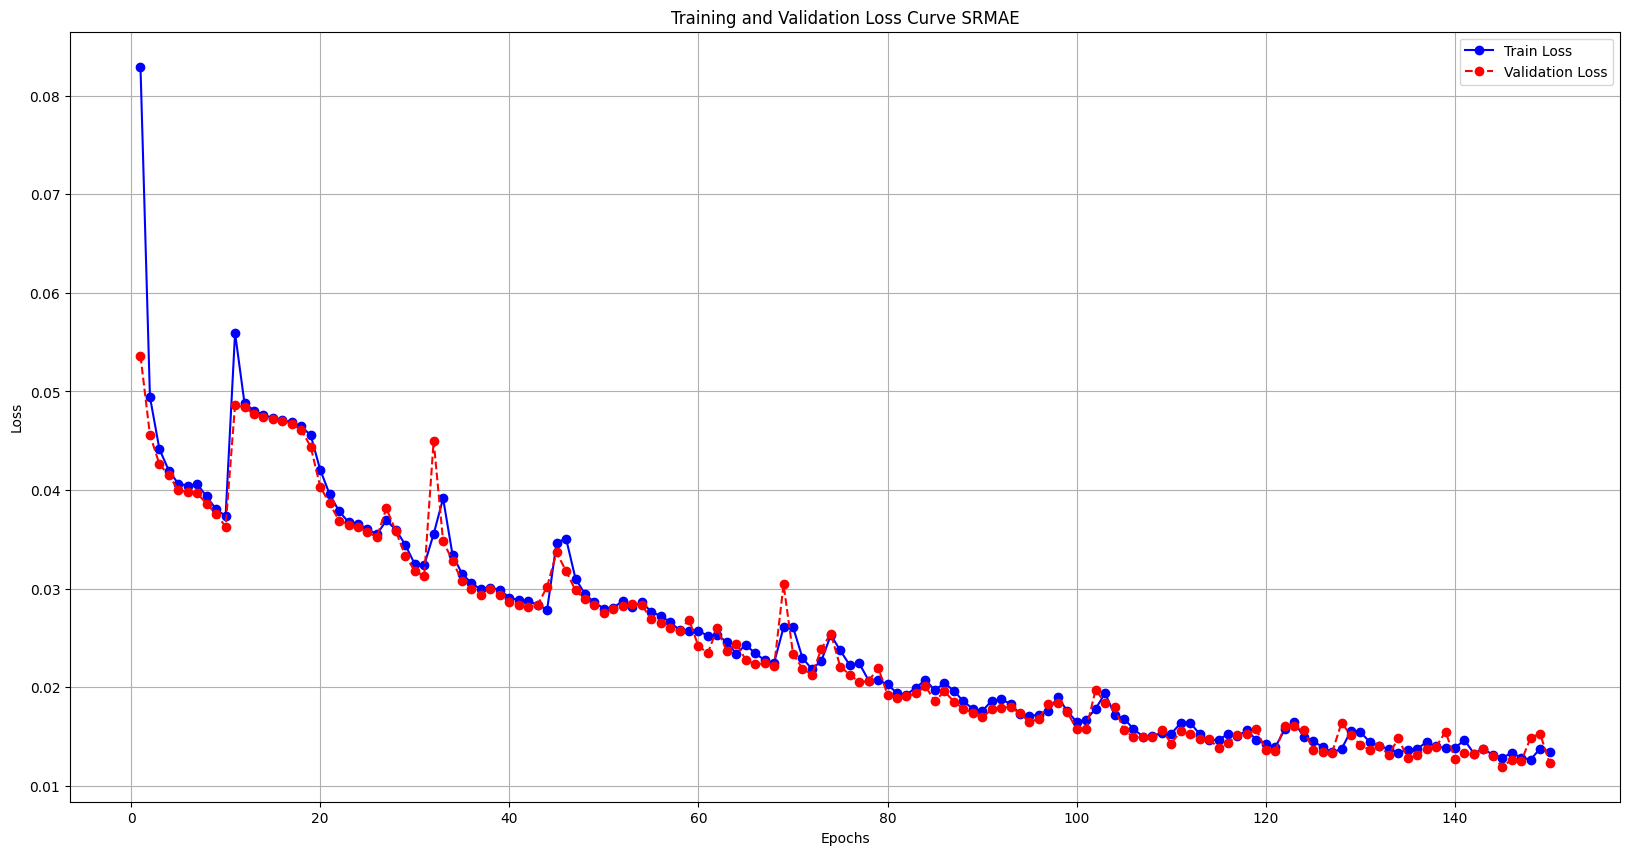

In [22]:


# Ensure train_losses and val_losses are on CPU & converted to NumPy
train_losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# X-axis values (Epoch numbers)
x = list(range(1, len(train_losses) + 1))

# Plot
plt.figure(figsize=(20, 10))
plt.plot(x, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(x, val_losses, marker='o', linestyle='--', color='r', label='Validation Loss')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve SRMAE')
plt.legend()
plt.grid()

# Show Plot
plt.show()


## FULL FINETUNING WITH UNFREEZED ENCODER. ~7.38M params

```
With freezed encoder we easily surpass 30 PSNR, indicating decent feature learning by encoder.
So, the lr for encoder is kept lower than other layers.
```

In [31]:
model

DataParallel(
  (module): SuperResolutionMAE(
    (encoder): Encoder(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 256, kernel_size=(4, 4), stride=(4, 4))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-7): 8 x Block(
          (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=256, out_features=768, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=256, out_features=256, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0

<ipython-input-38-4aec51037a80>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/working/best_sr_mae_model.pth")


Total number of trainable parameters: 7385165


Epoch 1/50 [Val]: 100%|██████████| 2/2 [00:06<00:00,  3.34s/batch]


Epoch 1/50, Train Loss: 0.019621, Train MSE: 0.002797, Val Loss: 0.014634, Val MSE: 0.001514, PSNR: 28.1979, SSIM: 0.9333

Best model 'SRMAE' saved with PSNR: 28.1979


Epoch 2/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 2/50, Train Loss: 0.013630, Train MSE: 0.001254, Val Loss: 0.012708, Val MSE: 0.001073, PSNR: 29.6945, SSIM: 0.9475

Best model 'SRMAE' saved with PSNR: 29.6945


Epoch 3/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 3/50, Train Loss: 0.012268, Train MSE: 0.000976, Val Loss: 0.012022, Val MSE: 0.000941, PSNR: 30.2663, SSIM: 0.9509

Best model 'SRMAE' saved with PSNR: 30.2663


Epoch 4/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.41s/batch]


Epoch 4/50, Train Loss: 0.011753, Train MSE: 0.000881, Val Loss: 0.012320, Val MSE: 0.000905, PSNR: 30.4333, SSIM: 0.9540

Best model 'SRMAE' saved with PSNR: 30.4333


Epoch 5/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 5/50, Train Loss: 0.011716, Train MSE: 0.000870, Val Loss: 0.011440, Val MSE: 0.000810, PSNR: 30.9146, SSIM: 0.9559

Best model 'SRMAE' saved with PSNR: 30.9146


Epoch 6/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.32s/batch]


Epoch 6/50, Train Loss: 0.011491, Train MSE: 0.000827, Val Loss: 0.011244, Val MSE: 0.000802, PSNR: 30.9590, SSIM: 0.9563

Best model 'SRMAE' saved with PSNR: 30.9590


Epoch 7/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.37s/batch]


Epoch 7/50, Train Loss: 0.011519, Train MSE: 0.000831, Val Loss: 0.011591, Val MSE: 0.000799, PSNR: 30.9765, SSIM: 0.9563

Best model 'SRMAE' saved with PSNR: 30.9765


Epoch 8/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.33s/batch]


Epoch 8/50, Train Loss: 0.011312, Train MSE: 0.000791, Val Loss: 0.011809, Val MSE: 0.000895, PSNR: 30.4833, SSIM: 0.9512



Epoch 9/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.30s/batch]


Epoch 9/50, Train Loss: 0.011139, Train MSE: 0.000762, Val Loss: 0.011921, Val MSE: 0.000991, PSNR: 30.0434, SSIM: 0.9523



Epoch 10/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.31s/batch]


Epoch 10/50, Train Loss: 0.011453, Train MSE: 0.000817, Val Loss: 0.010981, Val MSE: 0.000744, PSNR: 31.2820, SSIM: 0.9580

Best model 'SRMAE' saved with PSNR: 31.2820


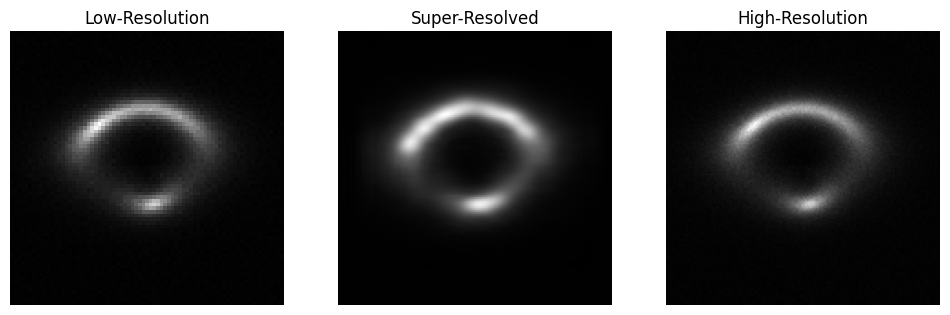

Epoch 11/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.31s/batch]


Epoch 11/50, Train Loss: 0.011744, Train MSE: 0.000851, Val Loss: 0.011027, Val MSE: 0.000742, PSNR: 31.2966, SSIM: 0.9575

Best model 'SRMAE' saved with PSNR: 31.2966


Epoch 12/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.25s/batch]


Epoch 12/50, Train Loss: 0.011314, Train MSE: 0.000787, Val Loss: 0.011072, Val MSE: 0.000773, PSNR: 31.1171, SSIM: 0.9578



Epoch 13/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.31s/batch]


Epoch 13/50, Train Loss: 0.010961, Train MSE: 0.000730, Val Loss: 0.010991, Val MSE: 0.000724, PSNR: 31.4004, SSIM: 0.9590

Best model 'SRMAE' saved with PSNR: 31.4004


Epoch 14/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 14/50, Train Loss: 0.010777, Train MSE: 0.000699, Val Loss: 0.010935, Val MSE: 0.000687, PSNR: 31.6288, SSIM: 0.9594

Best model 'SRMAE' saved with PSNR: 31.6288


Epoch 15/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.37s/batch]


Epoch 15/50, Train Loss: 0.011102, Train MSE: 0.000753, Val Loss: 0.010725, Val MSE: 0.000685, PSNR: 31.6422, SSIM: 0.9600

Best model 'SRMAE' saved with PSNR: 31.6422


Epoch 16/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.41s/batch]


Epoch 16/50, Train Loss: 0.011176, Train MSE: 0.000751, Val Loss: 0.010660, Val MSE: 0.000684, PSNR: 31.6485, SSIM: 0.9595

Best model 'SRMAE' saved with PSNR: 31.6485


Epoch 17/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 17/50, Train Loss: 0.010911, Train MSE: 0.000712, Val Loss: 0.011212, Val MSE: 0.000709, PSNR: 31.4914, SSIM: 0.9603



Epoch 18/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.31s/batch]


Epoch 18/50, Train Loss: 0.011137, Train MSE: 0.000746, Val Loss: 0.010938, Val MSE: 0.000713, PSNR: 31.4700, SSIM: 0.9597



Epoch 19/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.29s/batch]


Epoch 19/50, Train Loss: 0.010757, Train MSE: 0.000690, Val Loss: 0.011487, Val MSE: 0.000720, PSNR: 31.4259, SSIM: 0.9587



Epoch 20/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 20/50, Train Loss: 0.010689, Train MSE: 0.000672, Val Loss: 0.010176, Val MSE: 0.000588, PSNR: 32.3110, SSIM: 0.9629

Best model 'SRMAE' saved with PSNR: 32.3110


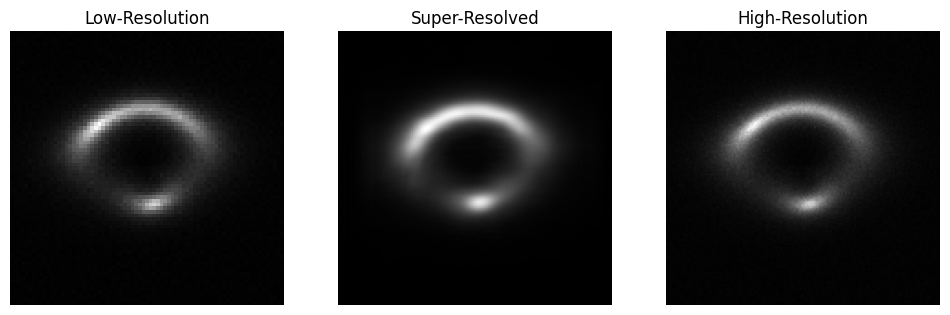

Epoch 21/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 21/50, Train Loss: 0.010465, Train MSE: 0.000639, Val Loss: 0.010122, Val MSE: 0.000605, PSNR: 32.1822, SSIM: 0.9625



Epoch 22/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.37s/batch]


Epoch 22/50, Train Loss: 0.010444, Train MSE: 0.000638, Val Loss: 0.010507, Val MSE: 0.000630, PSNR: 32.0082, SSIM: 0.9617



Epoch 23/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.41s/batch]


Epoch 23/50, Train Loss: 0.010624, Train MSE: 0.000666, Val Loss: 0.011540, Val MSE: 0.000871, PSNR: 30.6017, SSIM: 0.9559



Epoch 24/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.95s/batch]


Epoch 24/50, Train Loss: 0.010824, Train MSE: 0.000696, Val Loss: 0.010821, Val MSE: 0.000672, PSNR: 31.7275, SSIM: 0.9562



Epoch 25/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.29s/batch]


Epoch 25/50, Train Loss: 0.010360, Train MSE: 0.000616, Val Loss: 0.009949, Val MSE: 0.000558, PSNR: 32.5371, SSIM: 0.9640

Best model 'SRMAE' saved with PSNR: 32.5371


Epoch 26/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 26/50, Train Loss: 0.010591, Train MSE: 0.000641, Val Loss: 0.010362, Val MSE: 0.000578, PSNR: 32.3831, SSIM: 0.9635



Epoch 27/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.29s/batch]


Epoch 27/50, Train Loss: 0.010398, Train MSE: 0.000624, Val Loss: 0.010166, Val MSE: 0.000600, PSNR: 32.2220, SSIM: 0.9626



Epoch 28/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.40s/batch]


Epoch 28/50, Train Loss: 0.010187, Train MSE: 0.000590, Val Loss: 0.009933, Val MSE: 0.000557, PSNR: 32.5439, SSIM: 0.9633

Best model 'SRMAE' saved with PSNR: 32.5439


Epoch 29/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.30s/batch]


Epoch 29/50, Train Loss: 0.009960, Train MSE: 0.000561, Val Loss: 0.010092, Val MSE: 0.000569, PSNR: 32.4496, SSIM: 0.9629



Epoch 30/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.71s/batch]


Epoch 30/50, Train Loss: 0.009963, Train MSE: 0.000557, Val Loss: 0.009750, Val MSE: 0.000529, PSNR: 32.7643, SSIM: 0.9648

Best model 'SRMAE' saved with PSNR: 32.7643


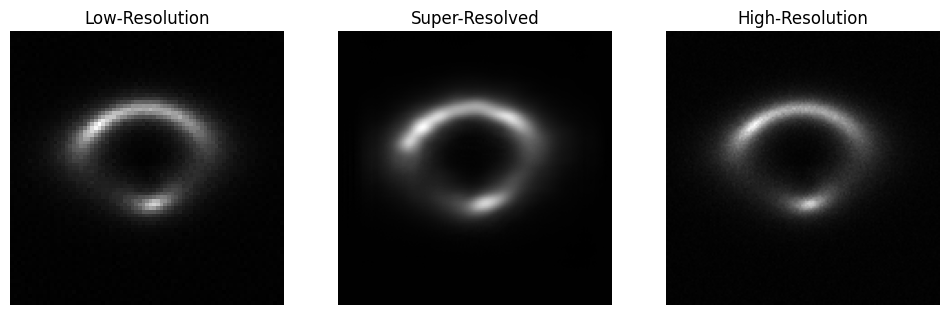

Epoch 31/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.64s/batch]


Epoch 31/50, Train Loss: 0.010080, Train MSE: 0.000571, Val Loss: 0.009922, Val MSE: 0.000564, PSNR: 32.4847, SSIM: 0.9630



Epoch 32/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.93s/batch]


Epoch 32/50, Train Loss: 0.010180, Train MSE: 0.000585, Val Loss: 0.010007, Val MSE: 0.000545, PSNR: 32.6365, SSIM: 0.9647



Epoch 33/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.58s/batch]


Epoch 33/50, Train Loss: 0.010345, Train MSE: 0.000612, Val Loss: 0.009912, Val MSE: 0.000537, PSNR: 32.7043, SSIM: 0.9645



Epoch 34/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.96s/batch]


Epoch 34/50, Train Loss: 0.010060, Train MSE: 0.000567, Val Loss: 0.010069, Val MSE: 0.000543, PSNR: 32.6529, SSIM: 0.9651



Epoch 35/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.78s/batch]


Epoch 35/50, Train Loss: 0.009807, Train MSE: 0.000534, Val Loss: 0.009549, Val MSE: 0.000498, PSNR: 33.0254, SSIM: 0.9659

Best model 'SRMAE' saved with PSNR: 33.0254


Epoch 36/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.69s/batch]


Epoch 36/50, Train Loss: 0.010006, Train MSE: 0.000556, Val Loss: 0.009488, Val MSE: 0.000487, PSNR: 33.1218, SSIM: 0.9661

Best model 'SRMAE' saved with PSNR: 33.1218


Epoch 37/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.78s/batch]


Epoch 37/50, Train Loss: 0.009851, Train MSE: 0.000535, Val Loss: 0.009906, Val MSE: 0.000562, PSNR: 32.5024, SSIM: 0.9644



Epoch 38/50 [Val]: 100%|██████████| 2/2 [00:07<00:00,  3.76s/batch]


Epoch 38/50, Train Loss: 0.009613, Train MSE: 0.000508, Val Loss: 0.009372, Val MSE: 0.000461, PSNR: 33.3666, SSIM: 0.9672

Best model 'SRMAE' saved with PSNR: 33.3666


Epoch 39/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.67s/batch]


Epoch 39/50, Train Loss: 0.009675, Train MSE: 0.000508, Val Loss: 0.011410, Val MSE: 0.000788, PSNR: 31.0348, SSIM: 0.9574



Epoch 40/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/batch]


Epoch 40/50, Train Loss: 0.009865, Train MSE: 0.000533, Val Loss: 0.009401, Val MSE: 0.000481, PSNR: 33.1809, SSIM: 0.9665



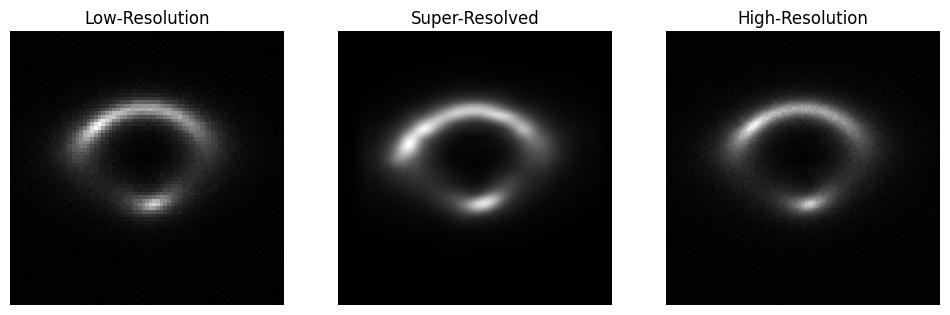

Epoch 41/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.34s/batch]


Epoch 41/50, Train Loss: 0.009707, Train MSE: 0.000512, Val Loss: 0.009298, Val MSE: 0.000462, PSNR: 33.3551, SSIM: 0.9667



Epoch 42/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.35s/batch]


Epoch 42/50, Train Loss: 0.009636, Train MSE: 0.000498, Val Loss: 0.009554, Val MSE: 0.000477, PSNR: 33.2177, SSIM: 0.9655



Epoch 43/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.39s/batch]


Epoch 43/50, Train Loss: 0.009617, Train MSE: 0.000499, Val Loss: 0.009501, Val MSE: 0.000498, PSNR: 33.0260, SSIM: 0.9667



Epoch 44/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.37s/batch]


Epoch 44/50, Train Loss: 0.009262, Train MSE: 0.000455, Val Loss: 0.009705, Val MSE: 0.000526, PSNR: 32.7871, SSIM: 0.9652



Epoch 45/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.38s/batch]


Epoch 45/50, Train Loss: 0.009490, Train MSE: 0.000482, Val Loss: 0.009119, Val MSE: 0.000425, PSNR: 33.7172, SSIM: 0.9681

Best model 'SRMAE' saved with PSNR: 33.7172


Epoch 46/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.25s/batch]


Epoch 46/50, Train Loss: 0.009601, Train MSE: 0.000497, Val Loss: 0.009195, Val MSE: 0.000442, PSNR: 33.5477, SSIM: 0.9670



Epoch 47/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.36s/batch]


Epoch 47/50, Train Loss: 0.009644, Train MSE: 0.000495, Val Loss: 0.009651, Val MSE: 0.000519, PSNR: 32.8501, SSIM: 0.9654



Epoch 48/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.40s/batch]


Epoch 48/50, Train Loss: 0.009619, Train MSE: 0.000496, Val Loss: 0.009584, Val MSE: 0.000481, PSNR: 33.1815, SSIM: 0.9655



Epoch 49/50 [Val]: 100%|██████████| 2/2 [00:05<00:00,  2.51s/batch]


Epoch 49/50, Train Loss: 0.009523, Train MSE: 0.000485, Val Loss: 0.010332, Val MSE: 0.000547, PSNR: 32.6241, SSIM: 0.9644



Epoch 50/50 [Val]: 100%|██████████| 2/2 [00:04<00:00,  2.50s/batch]


Epoch 50/50, Train Loss: 0.009665, Train MSE: 0.000502, Val Loss: 0.009090, Val MSE: 0.000429, PSNR: 33.6760, SSIM: 0.9680



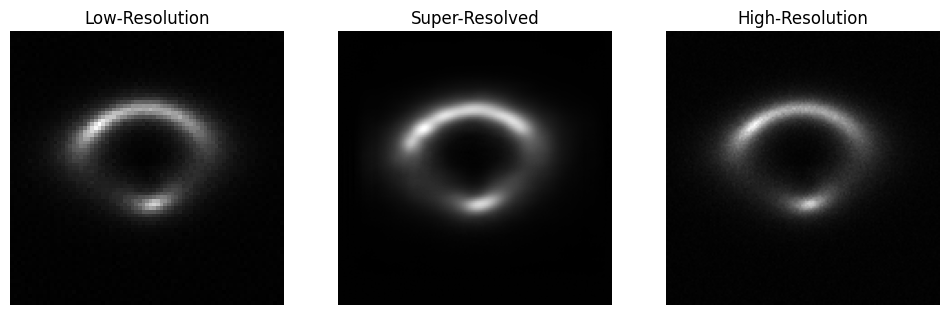

In [38]:
DEVICE = torch.device("cuda:0")
NUM_GPU = torch.cuda.device_count()

model = SuperResolutionMAE(pretrained_mae=mae)
ckpt = torch.load("/kaggle/working/best_sr_mae_model.pth")
new_state_dict = {k.replace("module.", ""):ckpt[k] for k in ckpt.keys()}
model.load_state_dict(new_state_dict)
model = model.to(DEVICE)

#Unfreeze Encoder
for param in model.encoder.parameters():
    param.requires_grad = True 

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 8e-5},  # Encoder with lower LR
    {'params': [p for n, p in model.named_parameters() if "encoder" not in n], 'lr': 5e-4}  # Others with common LR
], weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min = 8e-5)


if NUM_GPU > 1:
    model = nn.DataParallel(model)

epochs = 50

train_losses, val_losses = train_model(
    model, 
    epochs=epochs, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    device=DEVICE, 
    optimizer=optimizer, 
    scheduler=scheduler,
    log_file_path="./training_log_FT.txt",
    weights_path="./best_sr_mae_model_FT.pth",
    model_name="SRMAE",
    train_tqdm_tag="SR Full Train",
    val_tqdm_tag="Val"
)

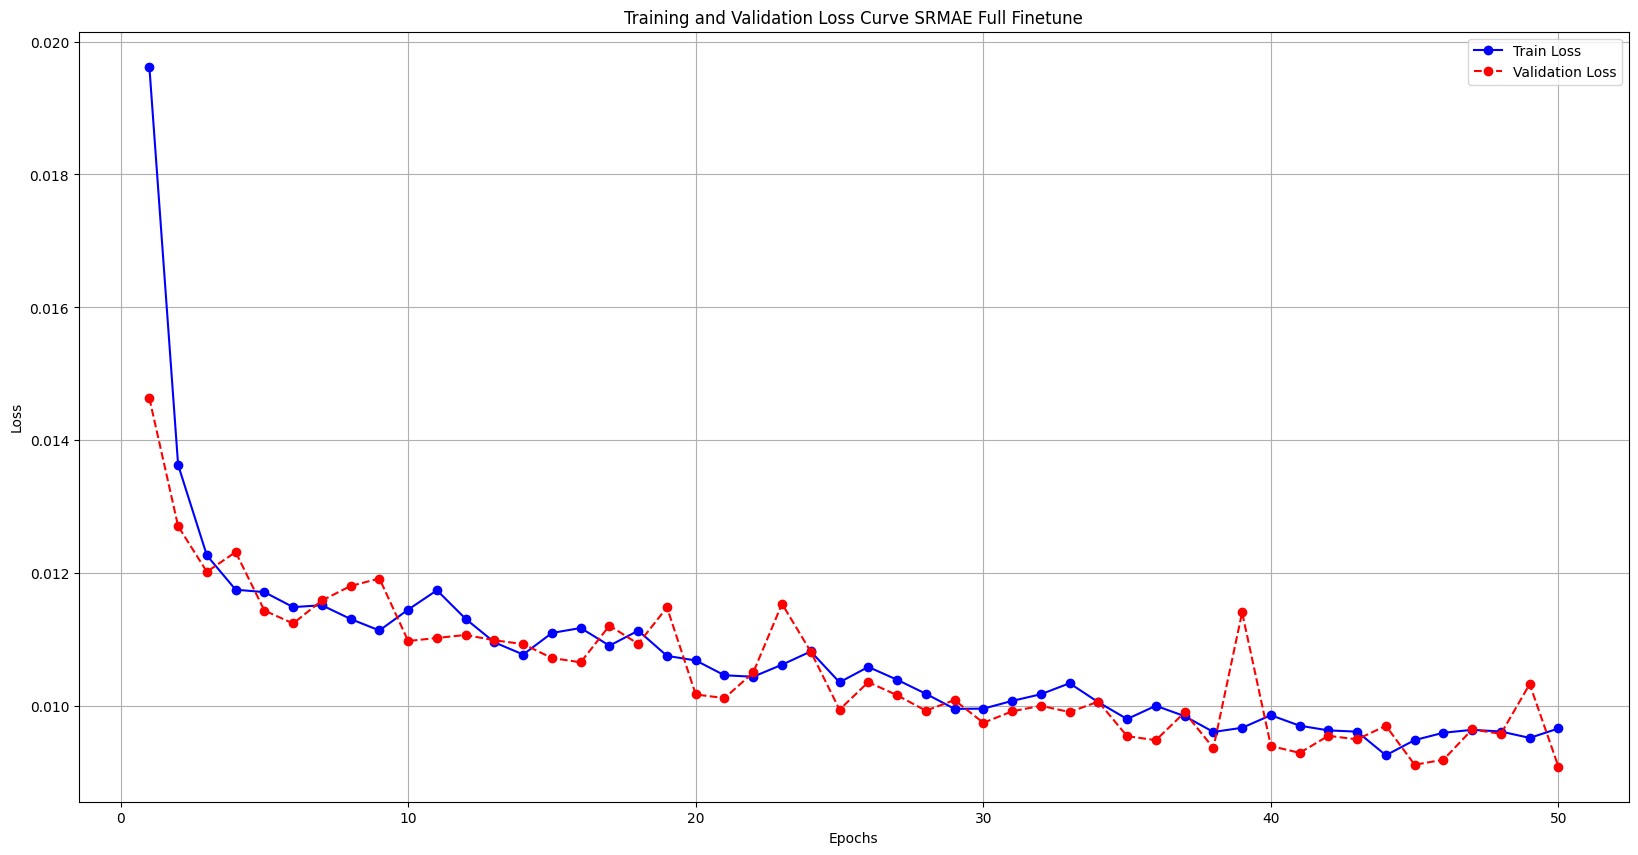

In [39]:


# Ensure train_losses and val_losses are on CPU & converted to NumPy
train_losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# X-axis values (Epoch numbers)
x = list(range(1, len(train_losses) + 1))

# Plot
plt.figure(figsize=(20, 10))
plt.plot(x, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(x, val_losses, marker='o', linestyle='--', color='r', label='Validation Loss')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve SRMAE Full Finetune')
plt.legend()
plt.grid()

# Show Plot
plt.show()


## VISUALISING IMAGE MAPS

In [52]:

def load_random_images(lr_path, hr_path, num_images=3):
    """Load random LR and HR images from the dataset."""
    # Get list of all .npy files
    lr_files = sorted([f for f in os.listdir(lr_path) if f.endswith('.npy')])
    hr_files = sorted([f for f in os.listdir(hr_path) if f.endswith('.npy')])

    # Select random indices
    random_indices = random.sample(range(len(lr_files)), num_images)

    lr_images = []
    hr_images = []

    for idx in random_indices:
        lr_images.append(np.load(os.path.join(lr_path, lr_files[idx])))
        hr_images.append(np.load(os.path.join(hr_path, hr_files[idx])))

    return np.array(lr_images), np.array(hr_images)

def plot_images(lr_images, sr_images, hr_images, num_images=3):
    """Plot LR, SR, HR images and their difference."""
    fig, axes = plt.subplots(num_images, 4, figsize=(12, 6))

    for i in range(num_images):
        lr_img = lr_images[i].squeeze()
        sr_img = sr_images[i].squeeze()
        hr_img = hr_images[i].squeeze()
        diff_img = np.abs(hr_img - sr_img)  # Difference image

        # Plot images
        axes[i, 0].imshow(lr_img, cmap='gray')
        axes[i, 0].set_title("LR Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(sr_img, cmap='gray')
        axes[i, 1].set_title("SR Output")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(hr_img, cmap='gray')
        axes[i, 2].set_title("HR Image")
        axes[i, 2].axis("off")

        axes[i, 3].imshow(diff_img, cmap='coolwarm') 
        axes[i, 3].set_title("Difference")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()




<ipython-input-55-f1b5f9502167>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/working/best_sr_mae_model_FT.pth")


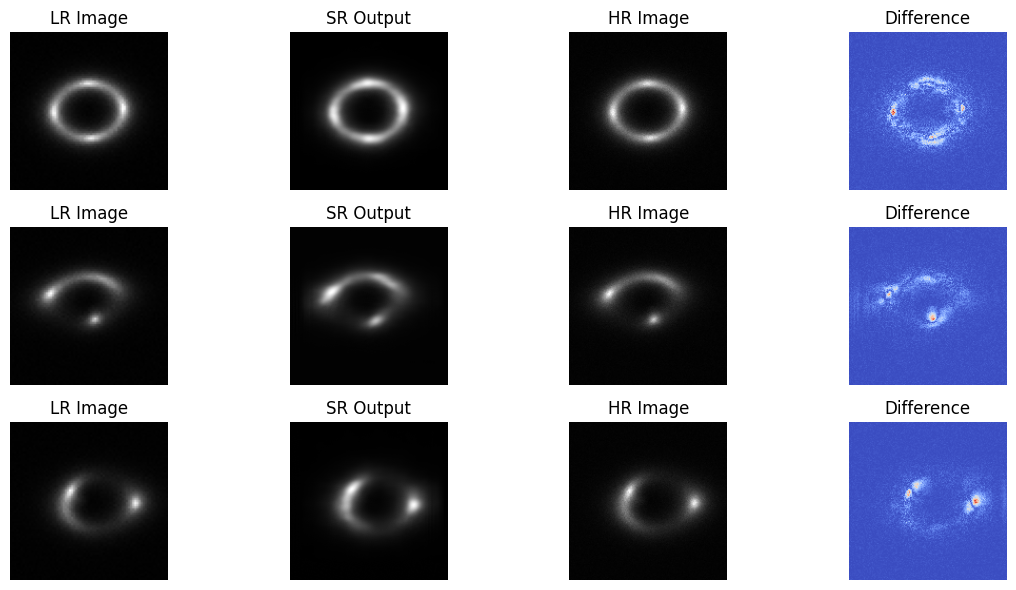

In [55]:
# Define paths to datasets
lr_dataset_path = "/kaggle/input/mae-sr-dataset-split/val/LR"
hr_dataset_path = "/kaggle/input/mae-sr-dataset-split/val/HR"

lr_images, hr_images = load_random_images(lr_dataset_path, hr_dataset_path, num_images=3)

# Convert to PyTorch tensors
lr_tensors = torch.tensor(lr_images).float()  # Add channel dim (B, C, H, W)

# Move to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr_tensors = lr_tensors.to(device)

# Load model and move to device
model = SuperResolutionMAE(pretrained_mae=mae)
ckpt = torch.load("/kaggle/working/best_sr_mae_model_FT.pth")
new_state_dict = {k.replace("module.", ""):ckpt[k] for k in ckpt.keys()}
model.load_state_dict(new_state_dict)
model = model.to(device)
model.eval()

# Generate Super-Resolved images
with torch.no_grad():
    sr_tensors = model(lr_tensors)

# Convert SR tensor back to numpy
sr_images = sr_tensors.cpu().numpy()

# Plot images
plot_images(lr_images, sr_images, hr_images, num_images=3)

In [43]:
lr_images.shape

(3, 1, 75, 75)

## VALIDATION SCORES

```
Validation Results:
1. PSNR: 30.3562, SSIM: 0.9524, MSE: 0.000921  --> Freezed Encoder
2. PSNR: 33.6931, SSIM: 0.9681, MSE: 0.000427  --> Full Finetune
```

In [66]:

def load_model(model_class, checkpoint_path, device='cpu'):

    # Load checkpoint
    ckpt = torch.load(checkpoint_path, map_location=device)

    # Handle 'module.' prefix from DataParallel/DistributedDataParallel
    new_state_dict = {k.replace("module.", ""): v for k, v in ckpt.items()}
    
    # Load state dictionary into model
    model.load_state_dict(new_state_dict)

    # Move model to device
    model.to(device)
    print(f"Model loaded successfully from {checkpoint_path} on {device}")
    return model


In [56]:
def evaluate_model(model, val_dataloader, device):
    model.eval()
    total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
    num_samples = 0

    with torch.no_grad():
        for lr_img, hr_img in tqdm(val_dataloader, desc="Evaluating", unit="batch"):
            # Move images to device
            lr_img = lr_img.to(device).float()
            hr_img = hr_img.to(device).float()

            # Super-resolve the LR image
            sr_img = model(lr_img)

            # Compute MSE loss
            mse_loss = F.mse_loss(sr_img, hr_img)
            total_mse += mse_loss.item()

            # Convert tensors to numpy for PSNR & SSIM calculation
            sr_np = sr_img.squeeze().cpu().numpy()
            hr_np = hr_img.squeeze().cpu().numpy()

            # Ensure data range is correct
            psnr_val = psnr(hr_np, sr_np, data_range=hr_np.max() - hr_np.min())
            ssim_val = ssim(hr_np, sr_np, data_range=hr_np.max() - hr_np.min(), multichannel=False)

            total_psnr += psnr_val
            total_ssim += ssim_val
            num_samples += 1

    # Compute average metrics
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples
    avg_mse = total_mse / num_samples

    print(f"Validation Results - PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}, MSE: {avg_mse:.6f}")
    return avg_psnr, avg_ssim, avg_mse


In [67]:
warnings.filterwarnings("ignore")
ckpt_path = "/kaggle/working/best_sr_mae_model_FT.pth"
load_model(SuperResolutionMAE(pretrained_mae=mae),ckpt_path)

avg_psnr, avg_ssim, avg_mse = evaluate_model(model, val_dataloader, device='cpu')

Model loaded successfully from /kaggle/working/best_sr_mae_model_FT.pth on cpu


Evaluating: 100%|██████████| 2/2 [01:03<00:00, 31.64s/batch]

Validation Results - PSNR: 33.6931, SSIM: 0.9681, MSE: 0.000427


In [68]:
warnings.filterwarnings("ignore")
print("With freezed encoder finetuning")

ckpt_path = "/kaggle/working/best_sr_mae_model.pth"
load_model(SuperResolutionMAE(pretrained_mae=mae),ckpt_path)

avg_psnr, avg_ssim, avg_mse = evaluate_model(model, val_dataloader, device='cpu')

With freezed encoder finetuning
Model loaded successfully from /kaggle/working/best_sr_mae_model.pth on cpu


Evaluating: 100%|██████████| 2/2 [01:03<00:00, 31.54s/batch]

Validation Results - PSNR: 30.3562, SSIM: 0.9524, MSE: 0.000921
